In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
EPOCHS = 20
k = 5000 # number of samples used to calculate loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

In [7]:
class MoreComplexNet(nn.Module):
    def __init__(self):
        super(MoreComplexNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 500, 1) #similar to 5-gram
        self.cnn_apt_2 = nn.Conv2d(500, 1000, 1)
        self.cnn_apt_3 = nn.Conv2d(1000, 500, 2)
        self.cnn_apt_4 = nn.Conv2d(500, 100, 2)
        self.cnn_apt_5 = nn.Conv2d(100, 10, 2)
        
        self.cnn_pep_1 = nn.Conv2d(1, 250, 1)
        self.cnn_pep_2 = nn.Conv2d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv2d(500, 250, 3)
        self.cnn_pep_4 = nn.Conv2d(250, 100, 2)
        self.cnn_pep_5 = nn.Conv2d(100, 10, 2)
        
        self.relu = nn.ReLU()
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.relu, self.cnn_apt_2, self.relu, self.cnn_apt_3, self.relu, self.cnn_apt_4, self.relu, self.cnn_apt_5)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.relu, self.cnn_pep_2, self.relu, self.cnn_pep_3, self.relu, self.cnn_pep_4, self.relu, self.cnn_pep_5)
        
        
        self.fc1 = nn.Linear(1010, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

## Helper methods

In [8]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("Number of iterations")
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, new_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.plot(new_recall, 'r', label='New recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("Number of iterations")
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=axes[0, 0])
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=axes[1, 0])
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=axes[0, 1])
    axes[0,0].set_title("New: not in dataset")
    axes[1,0].set_title("Train: in dataset")
    axes[0, 1].set_title("Test: in dataset")
    plt.show()

In [9]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [10]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3, #step size
        save_checkpoints=False): #save checkpoints
    
    optim = SGD(model.parameters(), lr=gamma)
    for j in range(EPOCHS):
        
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 

        test_losses = []
        test_recalls = []
        test_recall_outputs = []

        new_outputs = []
        new_recalls = []

        train_correct = 0
        test_correct = 0
        new_correct = 0
        
        for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
            if i == 0:
                continue
            model.train()
            optim.zero_grad() 
            x, y = convert(aptamer, peptide) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) 
            
            train_score = out.cpu().detach().numpy().flatten()[0] 
            if train_score > 0.6:
                train_correct += 1 
            train_recall_outputs.append(train_score) 

            optim.zero_grad() 
            y_pmf = get_y_pmf(pep_prime)
            x_prime, y_prime = convert(apt_prime, pep_prime) #sample x', y' from S_prime_train
            out_prime = update(x_prime, y_prime) #get score from S_prime_train
            if indicator == 0:
                factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
            else:
                factor = 2
            out_prime = out_prime*factor #adjust for IS
            #print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*indicator)
            #print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
            # Retain graph retains the graph for further operations
            (lamb*indicator*out_prime - log_out).backward(retain_graph=True) 
            optim.step()

            with torch.no_grad():
                model.eval()
            
            x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
            test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
            test_recall_outputs.append(test_score) 
            if test_score > 0.6:
                test_correct += 1 

            #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
            for x, y in S_new[10*i:10*(i+1)]:
                x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                new_outputs.append(new_score)
                if new_score < 0.3:
                    new_correct += 1

            if i % 10000 == 0:
                train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
                #print("Train loss first part: ", lamb*get_out_prime("train"))
                #print("Train loss second part: ", get_log_out('train'))
                test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
                #print("Test loss first part: ", lamb*get_out_prime("test"))
                #print("Test loss second part: ", get_log_out('test'))
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                new_recall = 100*new_correct/(i*10) #generated dataset recall
                new_recalls.append(new_recall)
                if i > 1000:
                    train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                    test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                else:
                    train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
                test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


            if i % 100000 == 0:
                plot_recall(train_recalls, test_recalls, new_recalls, i, j, lamb, gamma)
                plot_loss(train_losses, test_losses, i, j, lamb, gamma)
                plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma)
                histogram(new_outputs[-1000:], train_recall_outputs[-1000:], test_recall_outputs[-1000:])
                print("New score: ", np.average(new_outputs[-50:]))
                print("Train score: ", np.average(train_score[-50:]))
                print("Test score: ", np.average(test_score[-50:]))
        # Save after every epoch
        if save_checkpoints:
            torch.save({'epoch': j,'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, '../models/model_checkpoints/mle_model.pth')
            

## Hyperparameter tuning

In [11]:
# Hyperparameter search
gammas = [1e-3, 1e-2]
lambdas = [10, 5, 2]

  0%|          | 0/473047 [00:00<?, ?it/s]

Lambda: 10 Gamma: 0.001


  1%|          | 5000/473047 [05:30<4:49:47, 26.92it/s]   

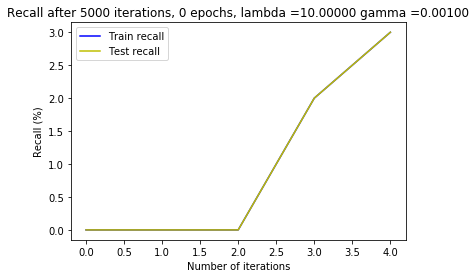

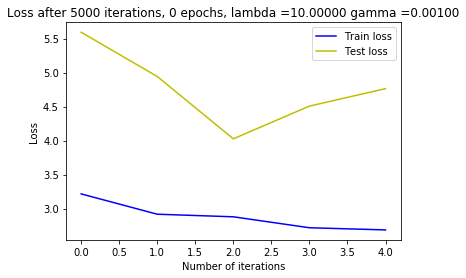

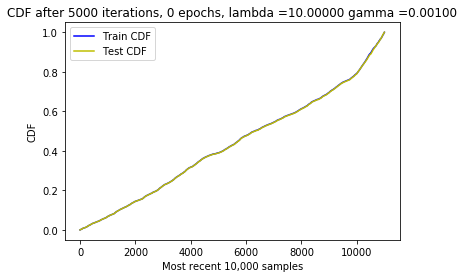

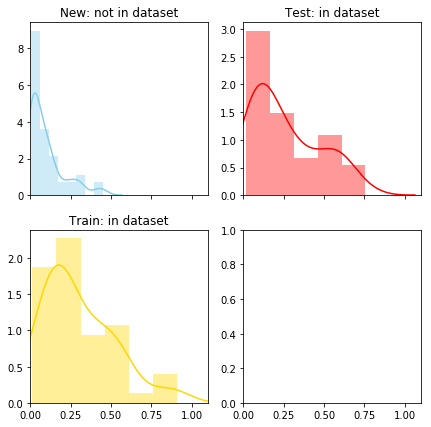

  1%|          | 5004/473047 [05:46<898:30:46,  6.91s/it] 

('New score: ', 0.09637835)
('Train score: ', 0.30381495)
('Test score: ', 0.26194993)


  2%|▏         | 10000/473047 [11:20<4:43:02, 27.27it/s]  

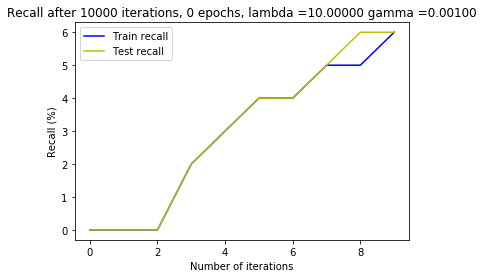

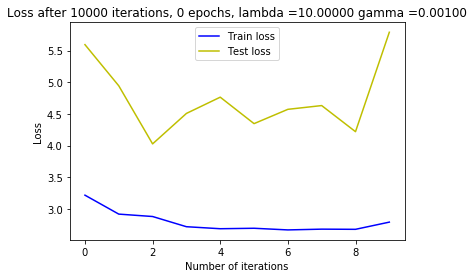

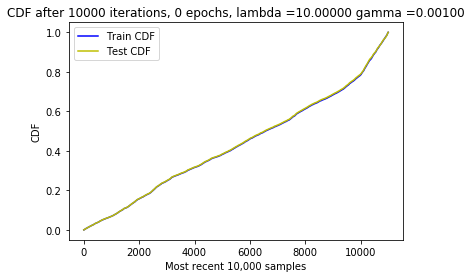

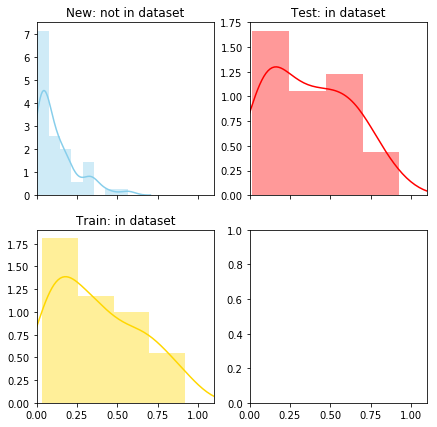

  2%|▏         | 10004/473047 [11:36<906:00:39,  7.04s/it] 

('New score: ', 0.12238539)
('Train score: ', 0.37436402)
('Test score: ', 0.374246)


  3%|▎         | 15000/473047 [17:20<5:34:11, 22.84it/s]   

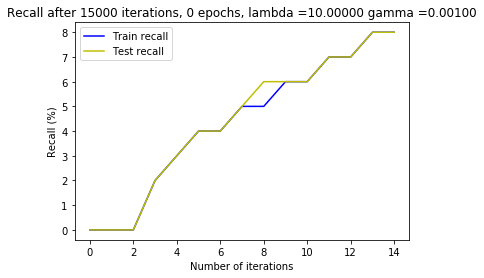

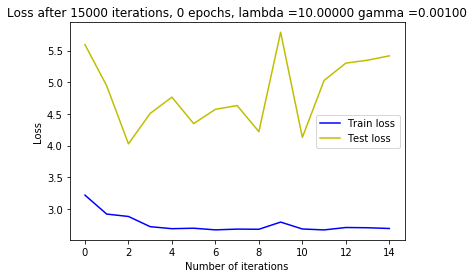

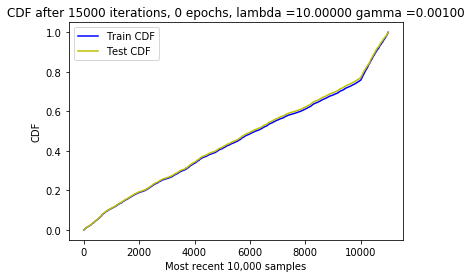

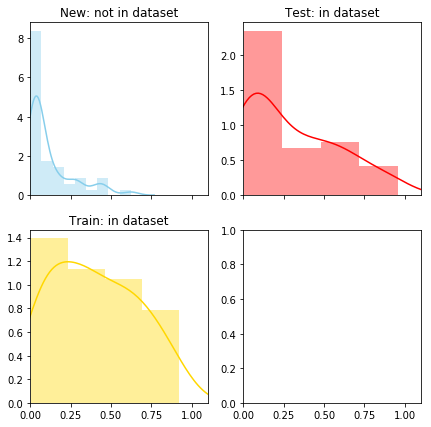

  3%|▎         | 15004/473047 [17:37<885:53:11,  6.96s/it] 

('New score: ', 0.11866838)
('Train score: ', 0.40159577)
('Test score: ', 0.30289406)


  4%|▍         | 20000/473047 [23:10<4:39:20, 27.03it/s]   

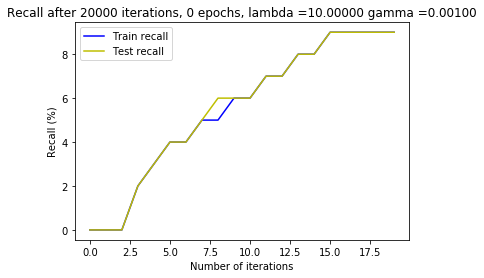

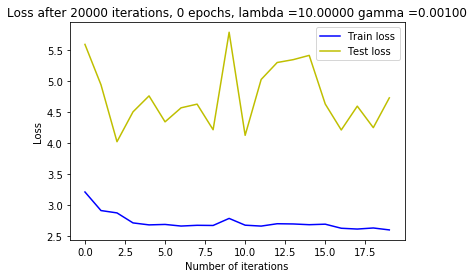

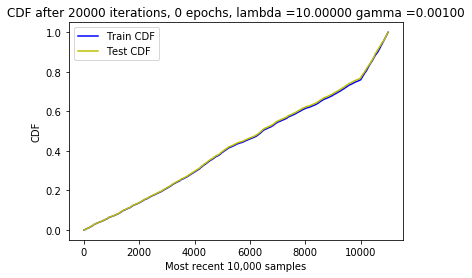

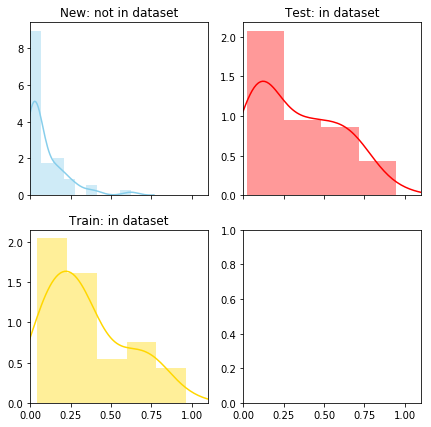

  4%|▍         | 20004/473047 [23:28<851:12:19,  6.76s/it] 

('New score: ', 0.09460112)
('Train score: ', 0.34908897)
('Test score: ', 0.33452848)


  5%|▌         | 25000/473047 [29:00<4:36:46, 26.98it/s]   

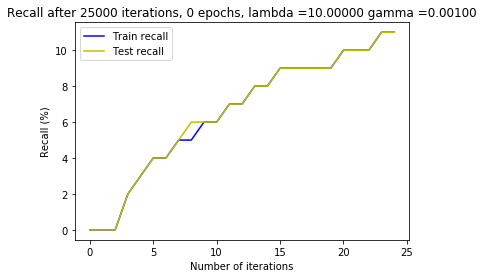

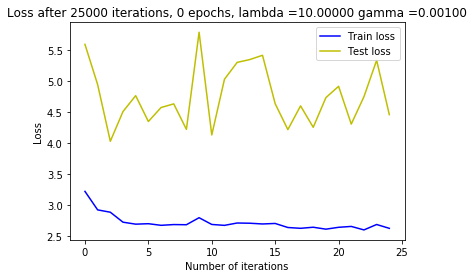

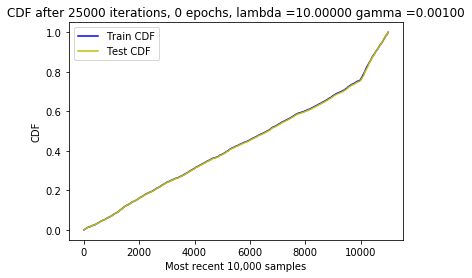

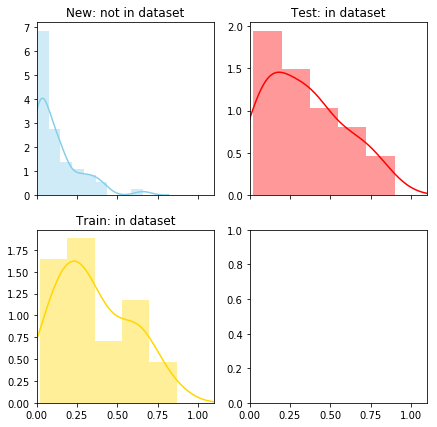

  5%|▌         | 25004/473047 [29:21<861:35:25,  6.92s/it] 

('New score: ', 0.12270238)
('Train score: ', 0.35306573)
('Test score: ', 0.3408173)


  6%|▋         | 30000/473047 [34:50<4:35:50, 26.77it/s]   

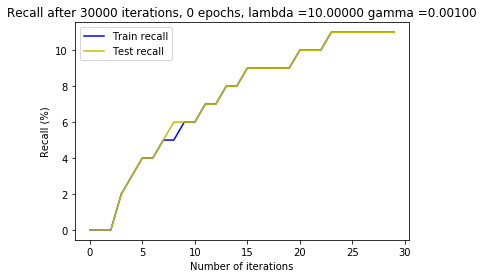

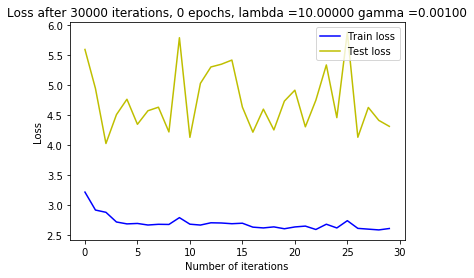

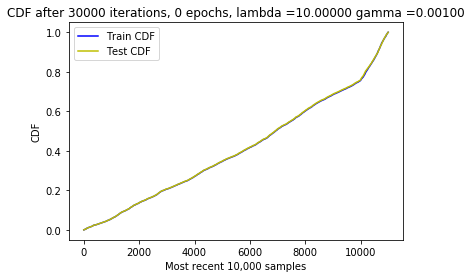

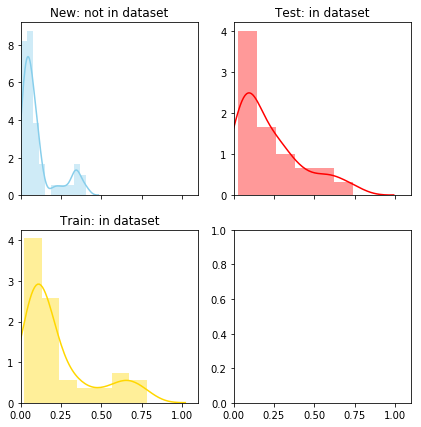

  6%|▋         | 30004/473047 [35:10<854:42:05,  6.94s/it] 

('New score: ', 0.10298328)
('Train score: ', 0.2290257)
('Test score: ', 0.22374037)


  7%|▋         | 35000/473047 [40:40<4:38:58, 26.17it/s]   

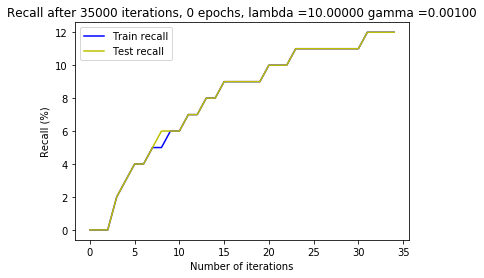

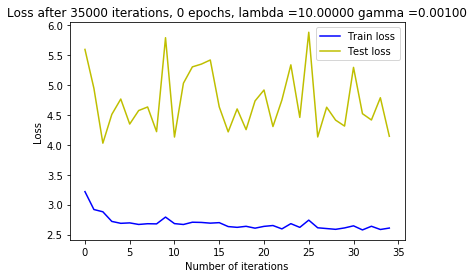

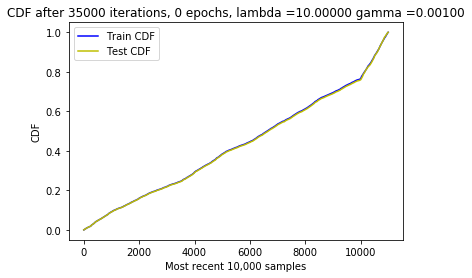

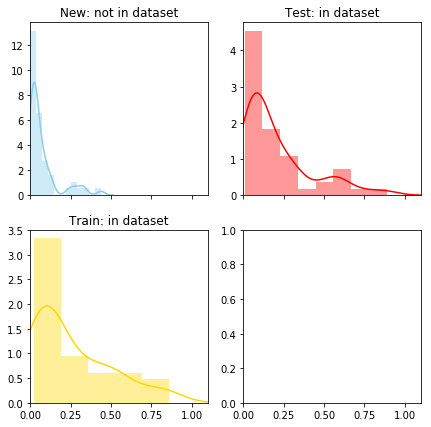

  7%|▋         | 35004/473047 [41:00<853:51:39,  7.02s/it] 

('New score: ', 0.07404038)
('Train score: ', 0.25796747)
('Test score: ', 0.20651096)


  8%|▊         | 40000/473047 [46:30<4:29:48, 26.75it/s]   

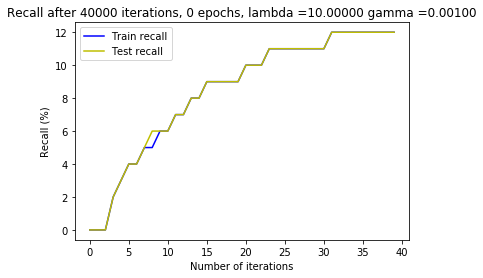

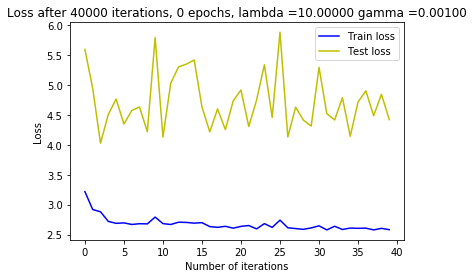

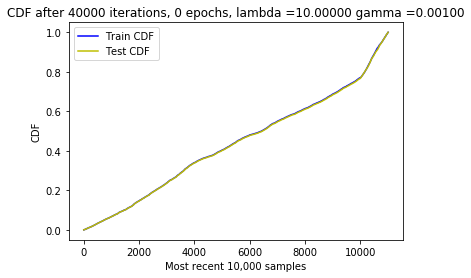

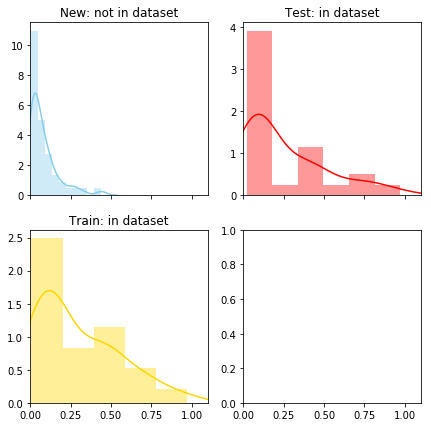

  8%|▊         | 40004/473047 [46:49<837:56:52,  6.97s/it] 

('New score: ', 0.08055952)
('Train score: ', 0.29289743)
('Test score: ', 0.2533436)


 10%|▉         | 45000/473047 [52:20<4:28:14, 26.60it/s]   

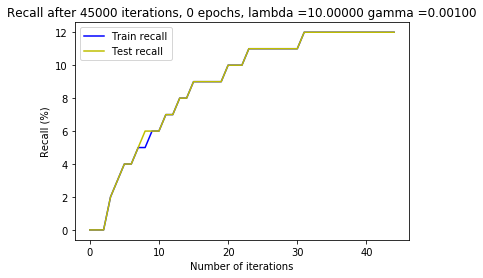

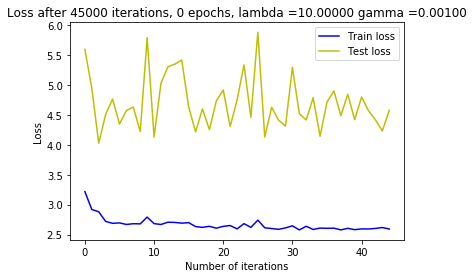

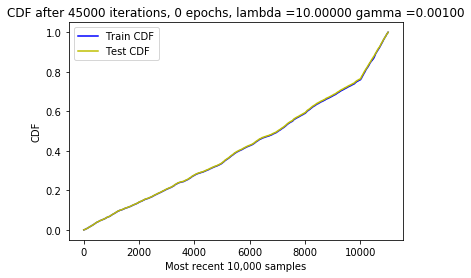

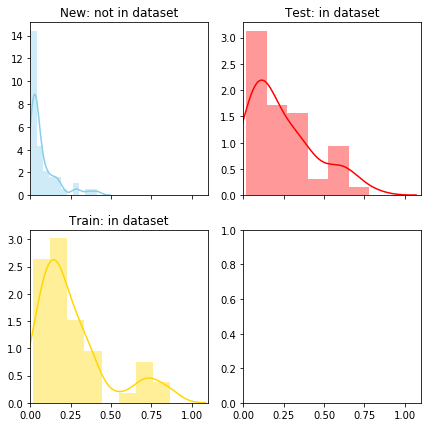

 10%|▉         | 45004/473047 [52:40<826:27:51,  6.95s/it] 

('New score: ', 0.076664396)
('Train score: ', 0.2613465)
('Test score: ', 0.24150229)


 11%|█         | 50000/473047 [58:10<4:21:31, 26.96it/s]   

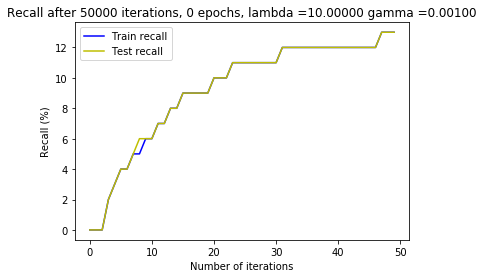

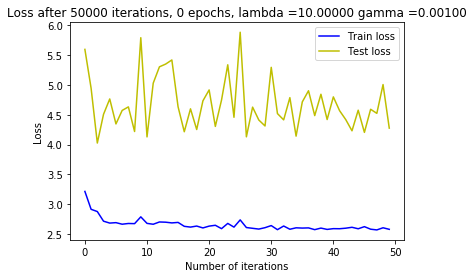

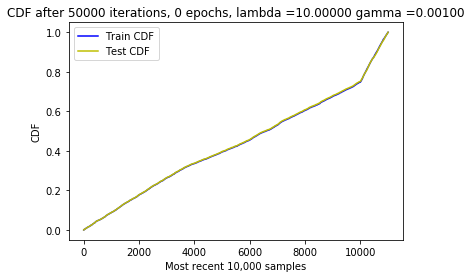

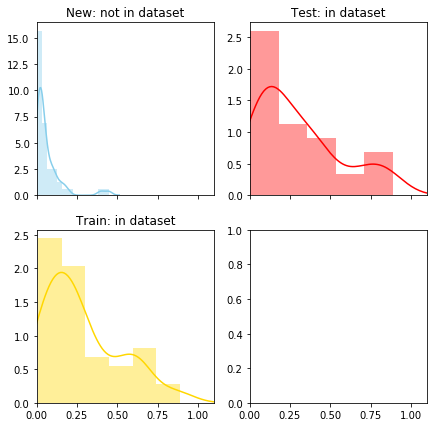

 11%|█         | 50004/473047 [58:29<819:24:54,  6.97s/it] 

('New score: ', 0.063900426)
('Train score: ', 0.28120542)
('Test score: ', 0.30333573)


 12%|█▏        | 55000/473047 [1:04:00<4:17:53, 27.02it/s]   

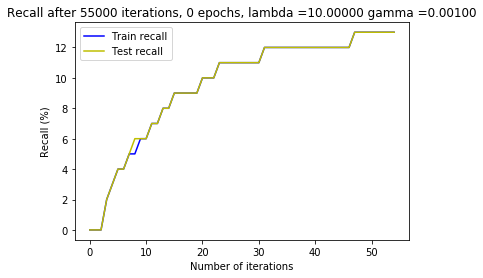

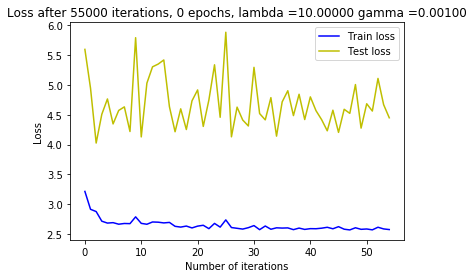

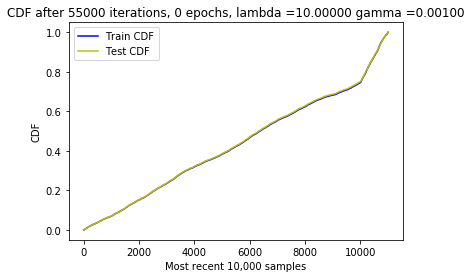

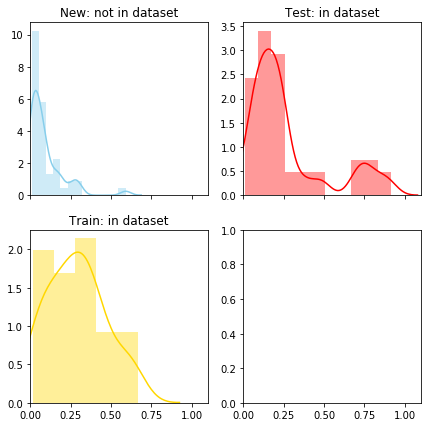

 12%|█▏        | 55004/473047 [1:04:20<804:09:00,  6.92s/it] 

('New score: ', 0.09250578)
('Train score: ', 0.2895493)
('Test score: ', 0.273643)


 13%|█▎        | 60000/473047 [1:09:50<4:13:29, 27.16it/s]   

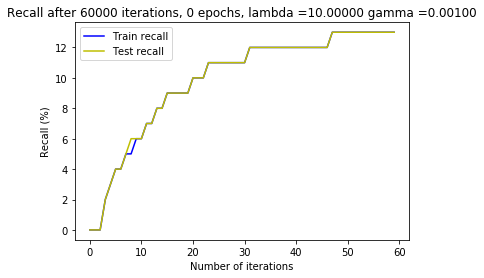

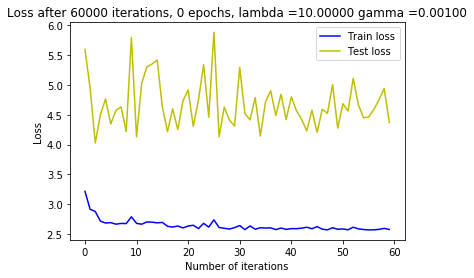

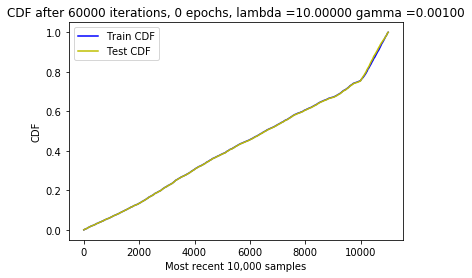

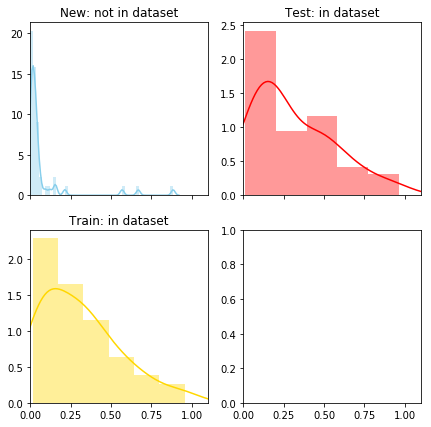

 13%|█▎        | 60004/473047 [1:10:07<779:33:47,  6.79s/it] 

('New score: ', 0.07649694)
('Train score: ', 0.30830073)
('Test score: ', 0.31326923)


 14%|█▎        | 65000/473047 [1:15:40<4:08:51, 27.33it/s]   

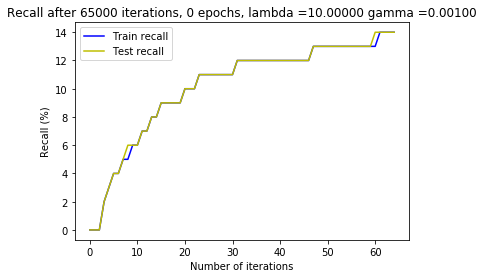

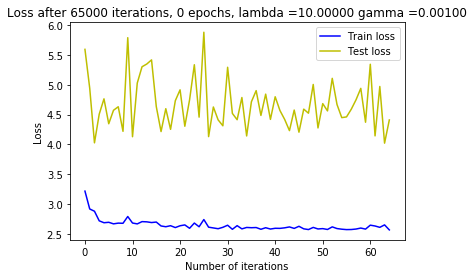

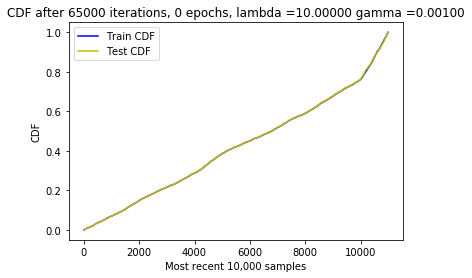

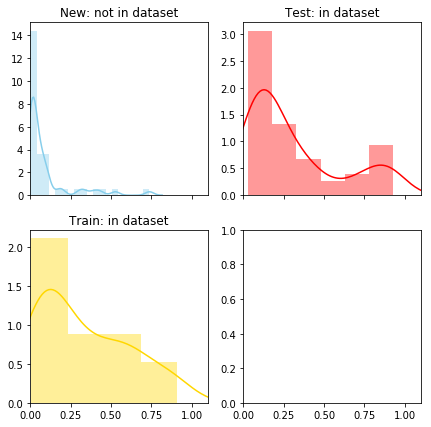

 14%|█▎        | 65004/473047 [1:15:55<776:02:00,  6.85s/it] 

('New score: ', 0.09189365)
('Train score: ', 0.33352527)
('Test score: ', 0.31293762)


 15%|█▍        | 70000/473047 [1:21:40<4:51:38, 23.03it/s]   

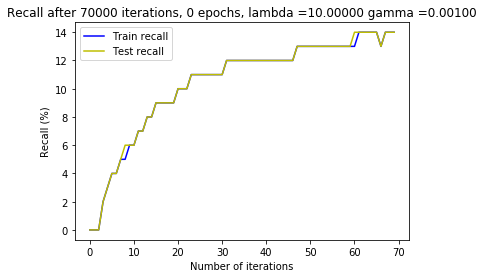

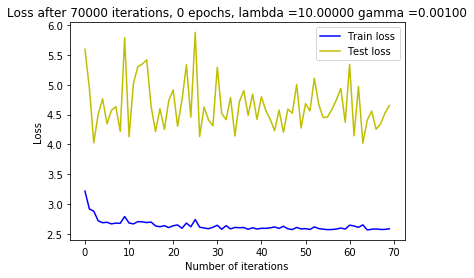

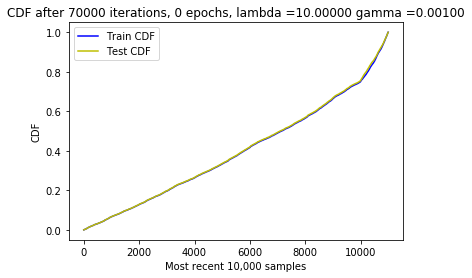

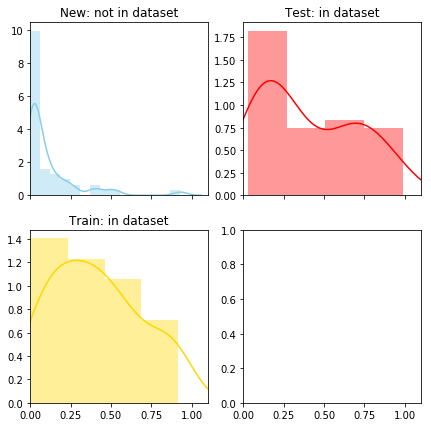

 15%|█▍        | 70004/473047 [1:21:54<767:33:04,  6.86s/it] 

('New score: ', 0.11321456)
('Train score: ', 0.4096181)
('Test score: ', 0.40507212)


 16%|█▌        | 75000/473047 [1:27:20<3:54:26, 28.30it/s]   

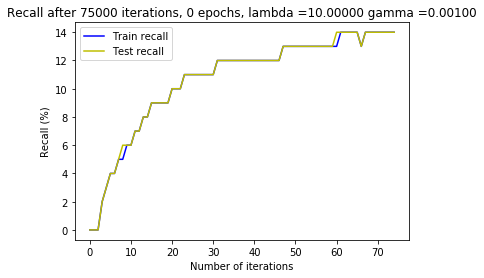

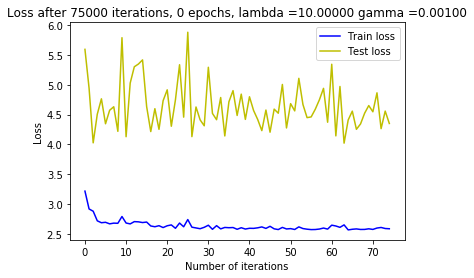

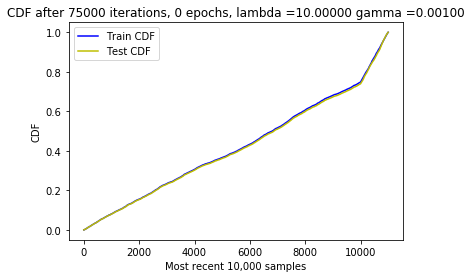

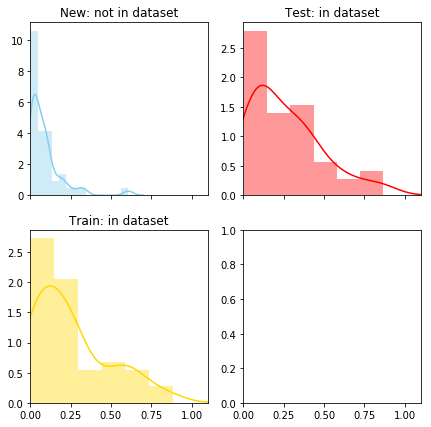

 16%|█▌        | 75004/473047 [1:27:41<779:26:49,  7.05s/it] 

('New score: ', 0.08813776)
('Train score: ', 0.25598794)
('Test score: ', 0.26210725)


 17%|█▋        | 80000/473047 [1:33:20<4:02:46, 26.98it/s]   

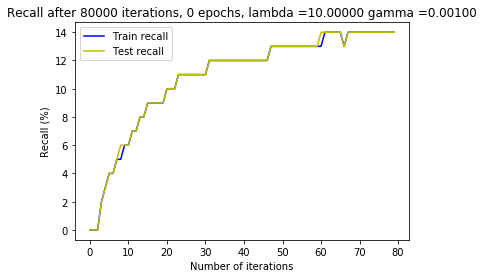

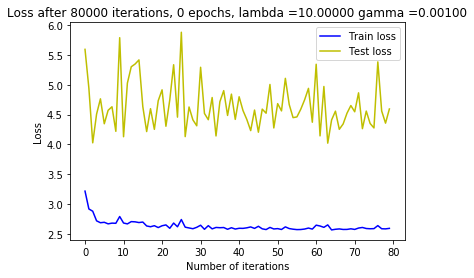

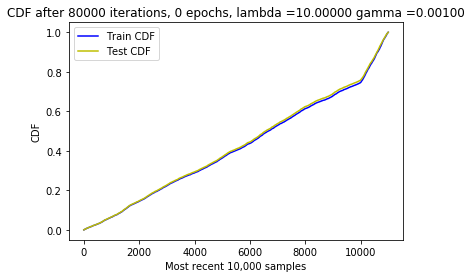

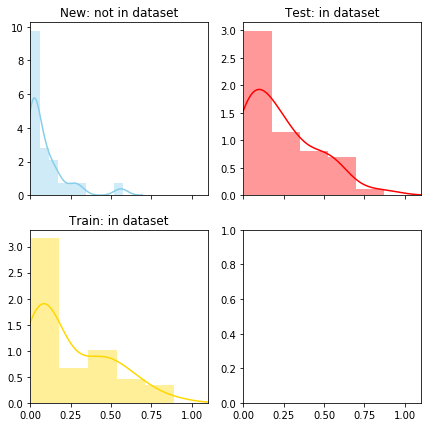

 17%|█▋        | 80004/473047 [1:33:40<783:23:48,  7.18s/it] 

('New score: ', 0.09296156)
('Train score: ', 0.25405416)
('Test score: ', 0.23480803)


 18%|█▊        | 85000/473047 [1:39:20<4:42:10, 22.92it/s]   

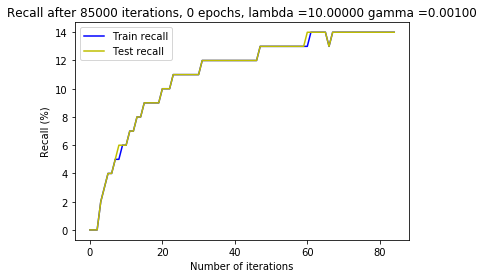

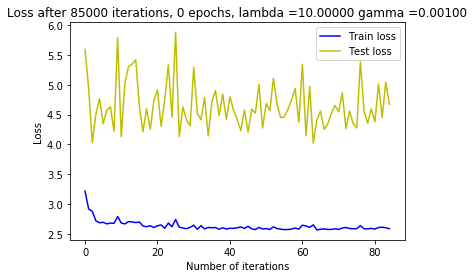

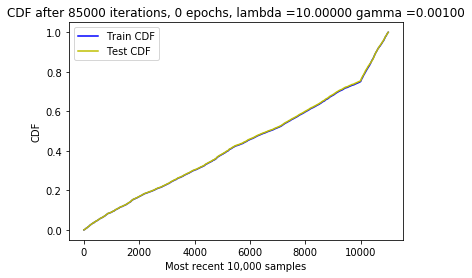

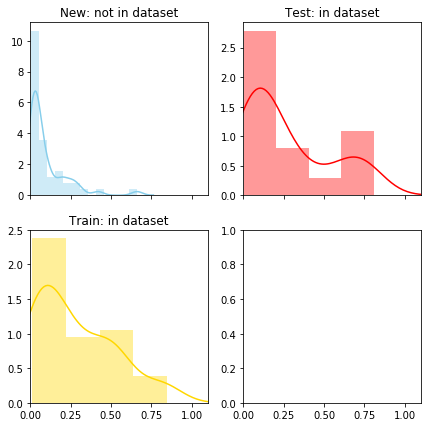

 18%|█▊        | 85004/473047 [1:39:42<757:48:24,  7.03s/it] 

('New score: ', 0.0978371)
('Train score: ', 0.2805586)
('Test score: ', 0.27282834)


 19%|█▉        | 90000/473047 [1:45:20<4:05:46, 25.97it/s]   

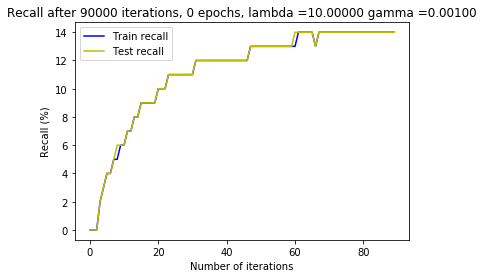

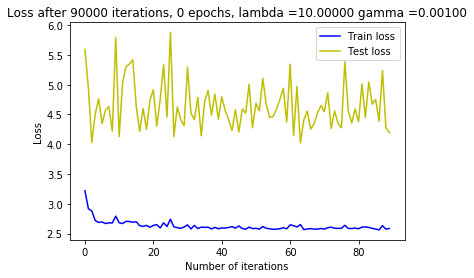

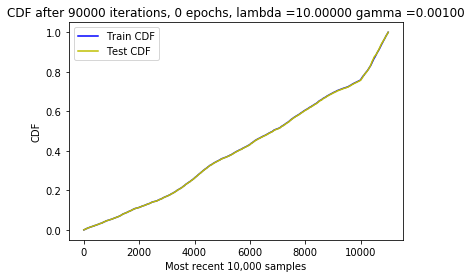

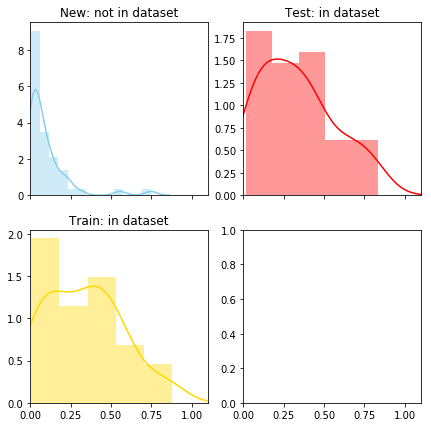

 19%|█▉        | 90004/473047 [1:45:39<739:40:18,  6.95s/it] 

('New score: ', 0.09754861)
('Train score: ', 0.33688393)
('Test score: ', 0.3321637)


 20%|██        | 95000/473047 [1:51:10<4:33:58, 23.00it/s]   

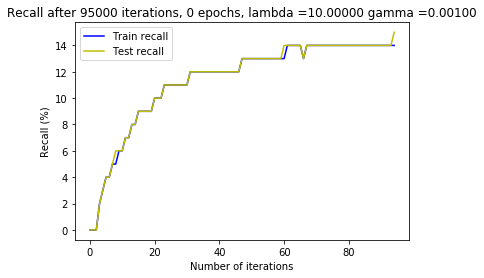

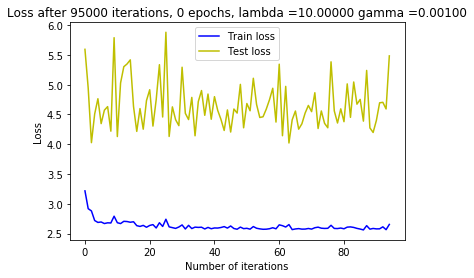

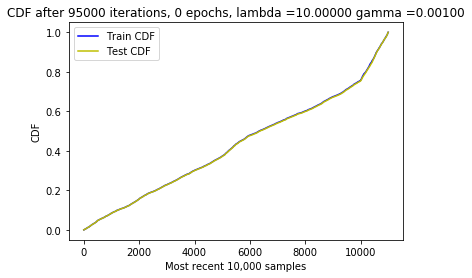

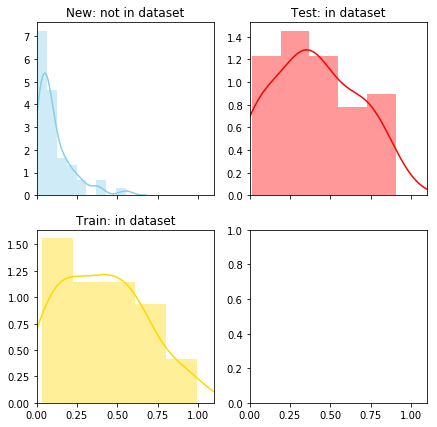

 20%|██        | 95004/473047 [1:51:28<739:14:07,  7.04s/it] 

('New score: ', 0.10775563)
('Train score: ', 0.40349084)
('Test score: ', 0.40501857)


 21%|██        | 100000/473047 [1:57:10<4:32:25, 22.82it/s]  

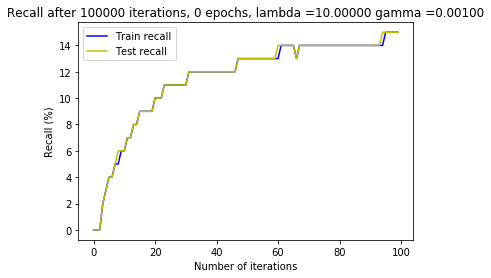

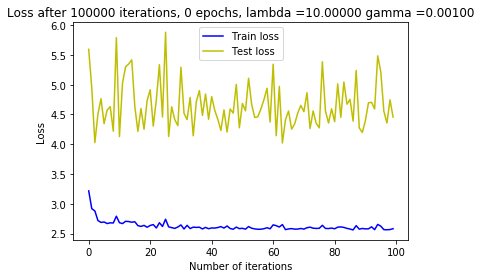

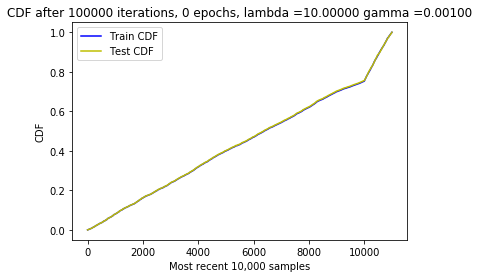

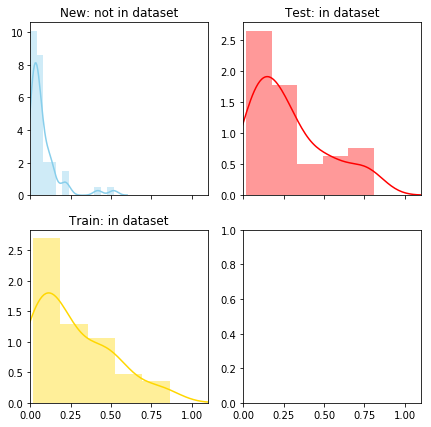

 21%|██        | 100004/473047 [1:57:25<720:32:38,  6.95s/it] 

('New score: ', 0.07769425)
('Train score: ', 0.2680952)
('Test score: ', 0.28454423)


 22%|██▏       | 105000/473047 [2:03:10<3:49:24, 26.74it/s]   

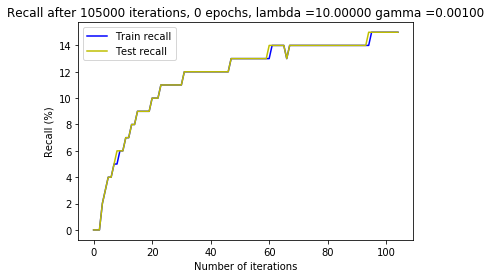

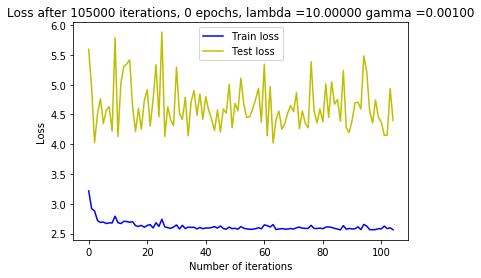

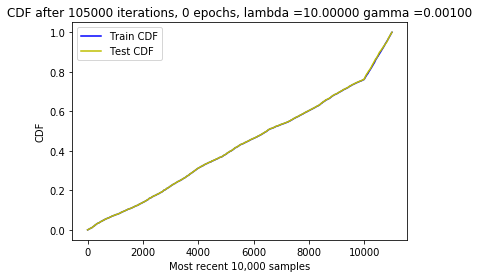

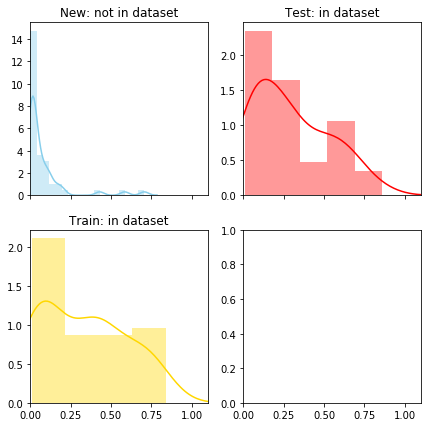

 22%|██▏       | 105004/473047 [2:03:24<714:33:50,  6.99s/it] 

('New score: ', 0.07882705)
('Train score: ', 0.33426934)
('Test score: ', 0.2982663)


 23%|██▎       | 110000/473047 [2:08:50<3:28:03, 29.08it/s]  

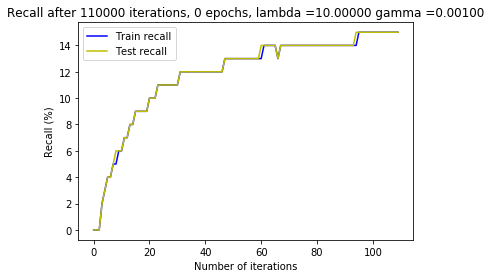

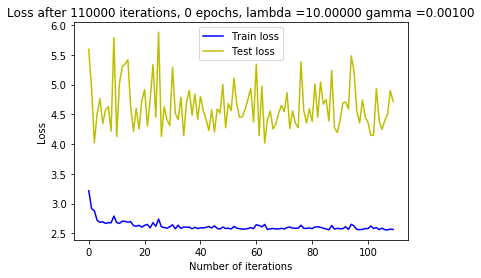

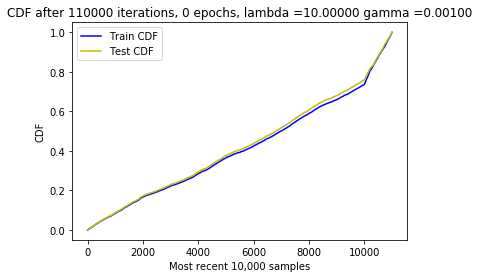

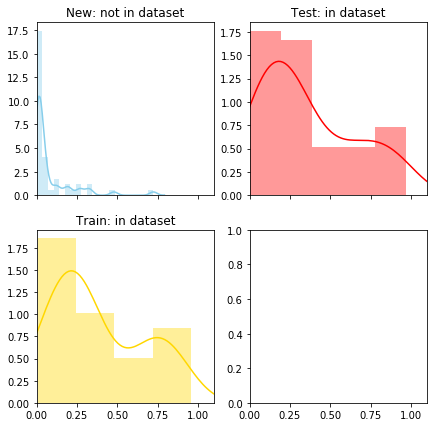

 23%|██▎       | 110004/473047 [2:09:05<700:18:50,  6.94s/it]

('New score: ', 0.08319144)
('Train score: ', 0.38256428)
('Test score: ', 0.35909542)


 24%|██▍       | 115000/473047 [2:14:20<3:40:39, 27.04it/s]  

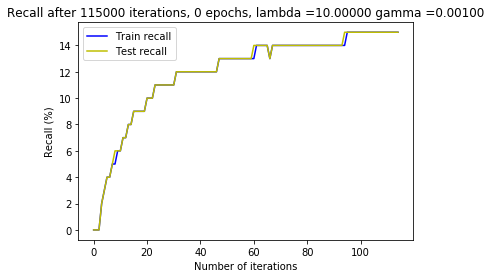

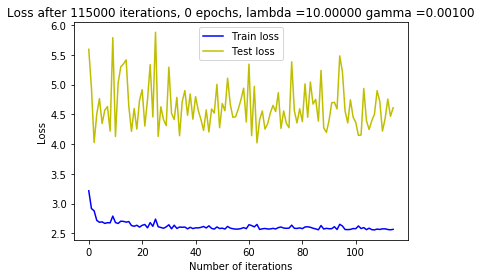

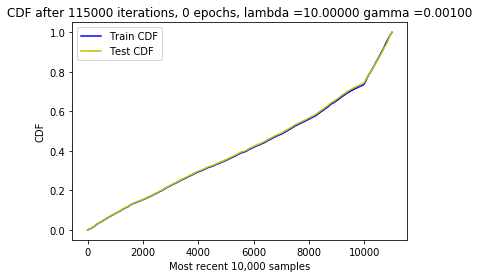

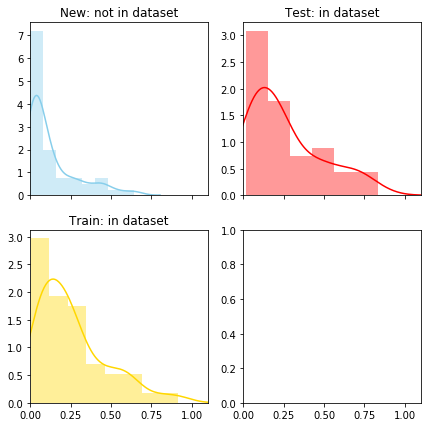

 24%|██▍       | 115004/473047 [2:14:42<681:59:11,  6.86s/it]

('New score: ', 0.12752923)
('Train score: ', 0.25837737)
('Test score: ', 0.2599436)


 25%|██▌       | 120000/473047 [2:20:10<3:36:56, 27.12it/s]  

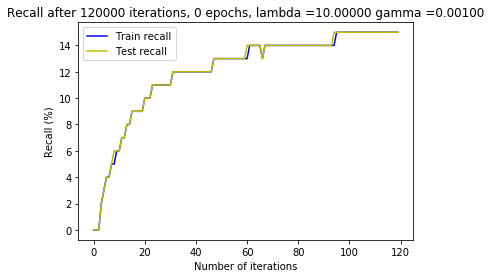

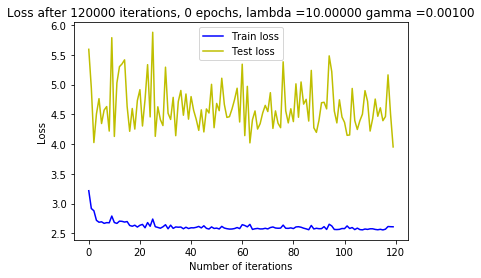

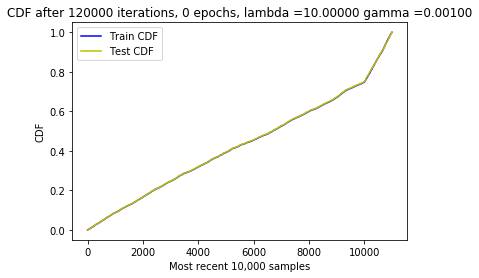

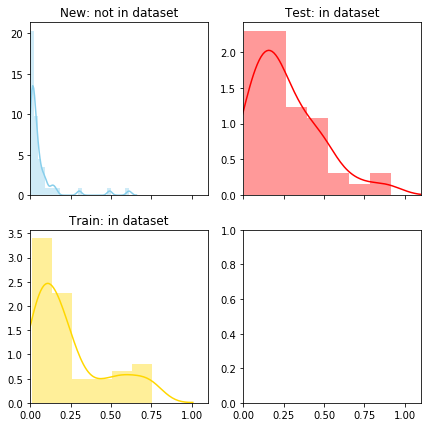

 25%|██▌       | 120004/473047 [2:20:27<672:06:38,  6.85s/it]

('New score: ', 0.06323627)
('Train score: ', 0.2423725)
('Test score: ', 0.2661565)


 26%|██▋       | 125000/473047 [2:25:50<4:12:07, 23.01it/s]  

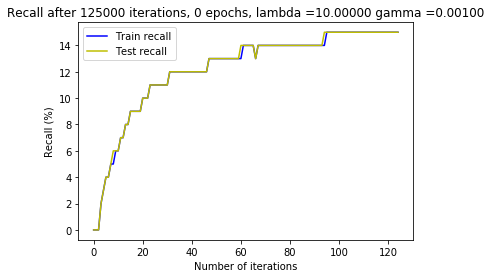

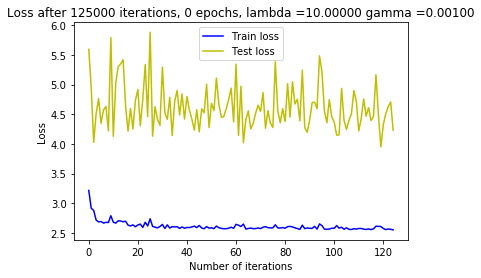

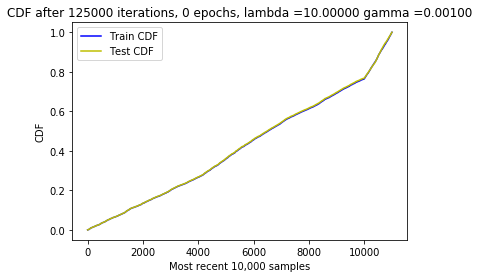

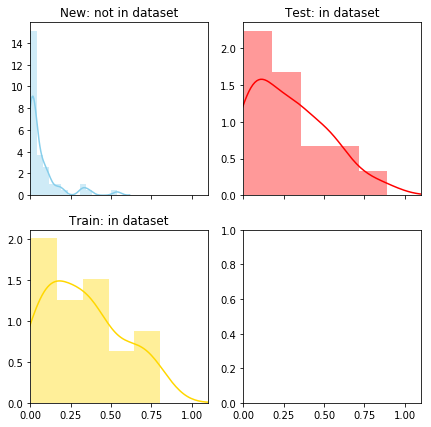

 26%|██▋       | 125004/473047 [2:26:13<665:21:24,  6.88s/it]

('New score: ', 0.070490785)
('Train score: ', 0.32639515)
('Test score: ', 0.28501323)


 27%|██▋       | 130000/473047 [2:31:40<3:30:20, 27.18it/s]  

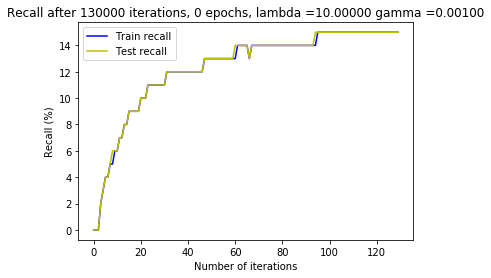

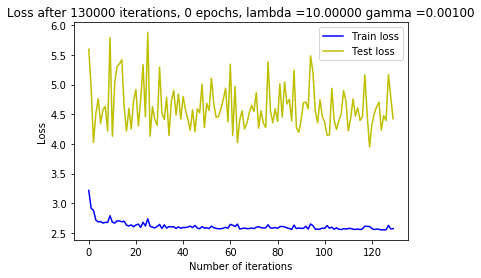

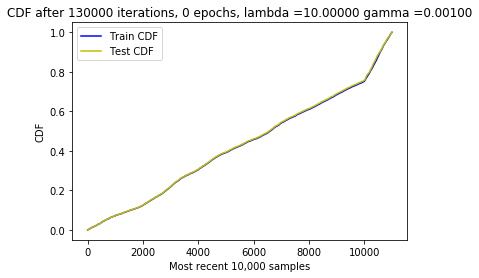

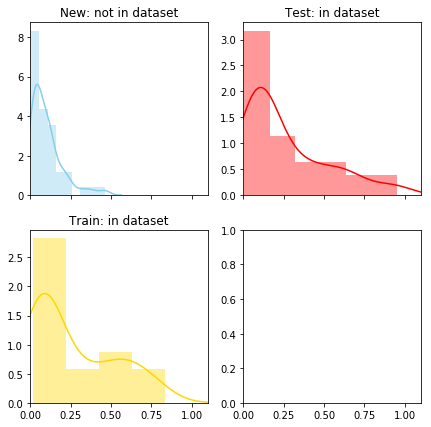

 27%|██▋       | 130004/473047 [2:31:56<652:23:41,  6.85s/it]

('New score: ', 0.10100922)
('Train score: ', 0.2684132)
('Test score: ', 0.26359317)


 29%|██▊       | 135000/473047 [2:37:20<3:27:13, 27.19it/s]  

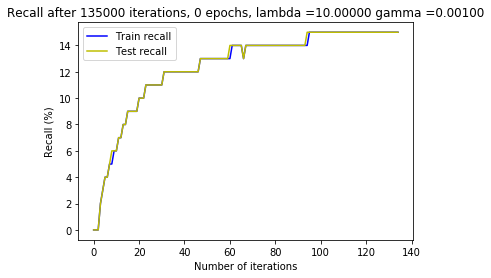

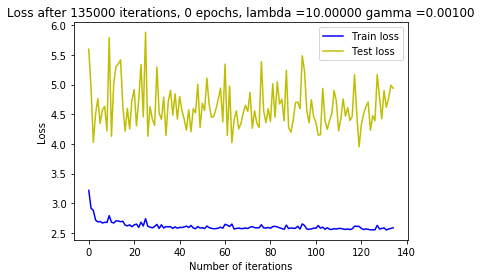

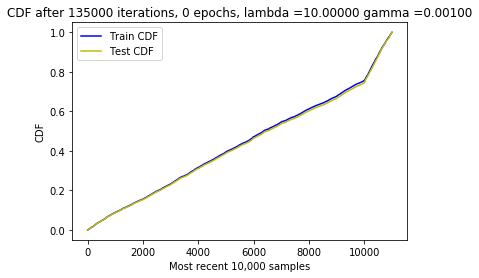

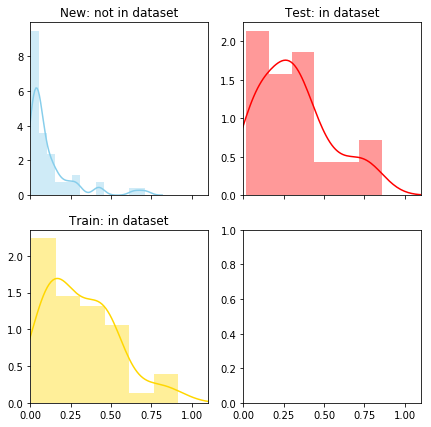

 29%|██▊       | 135004/473047 [2:37:41<643:20:20,  6.85s/it]

('New score: ', 0.11748696)
('Train score: ', 0.3134196)
('Test score: ', 0.31390134)


 30%|██▉       | 140000/473047 [2:43:10<3:26:44, 26.85it/s]  

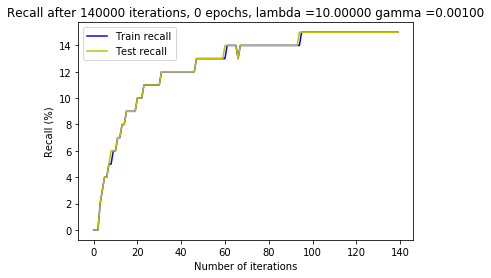

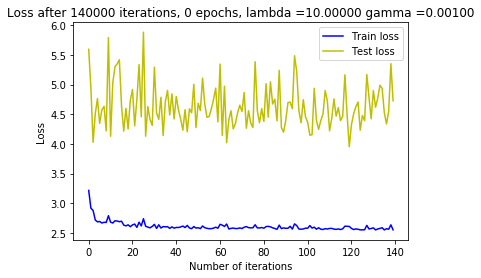

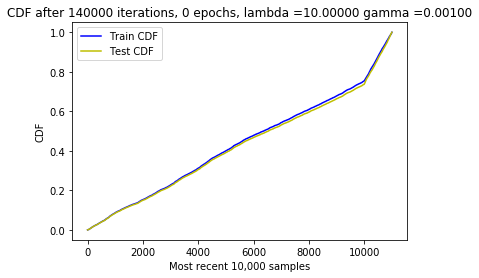

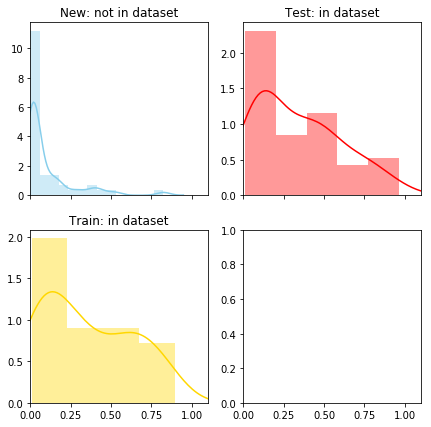

 30%|██▉       | 140004/473047 [2:43:26<632:08:31,  6.83s/it]

('New score: ', 0.10196985)
('Train score: ', 0.35566333)
('Test score: ', 0.344083)


 31%|███       | 145000/473047 [2:49:00<3:59:36, 22.82it/s]  

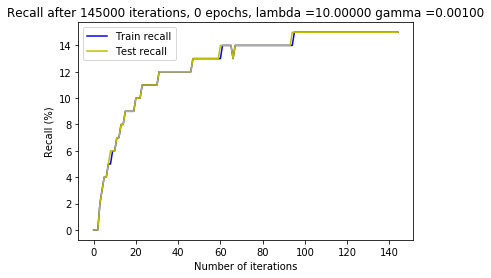

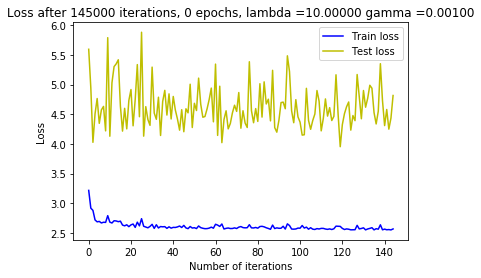

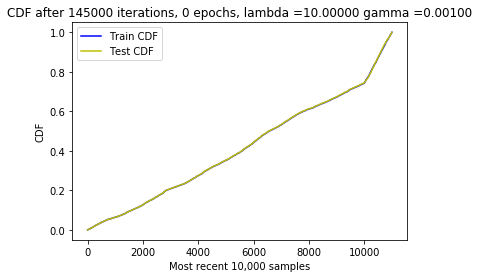

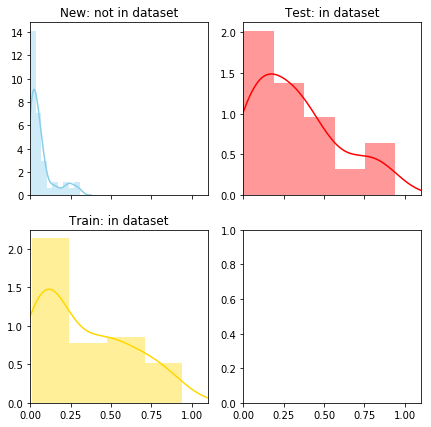

 31%|███       | 145004/473047 [2:49:23<637:02:30,  6.99s/it]

('New score: ', 0.065501146)
('Train score: ', 0.33301485)
('Test score: ', 0.32558554)


 32%|███▏      | 150000/473047 [2:55:00<3:21:29, 26.72it/s]  

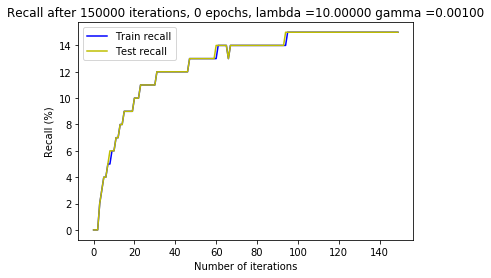

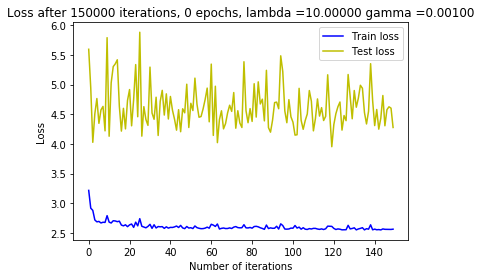

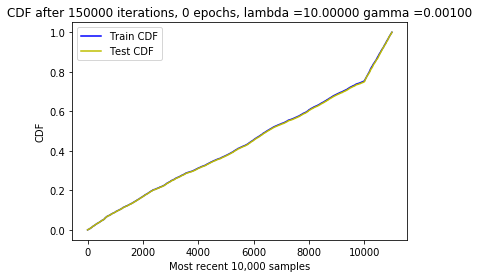

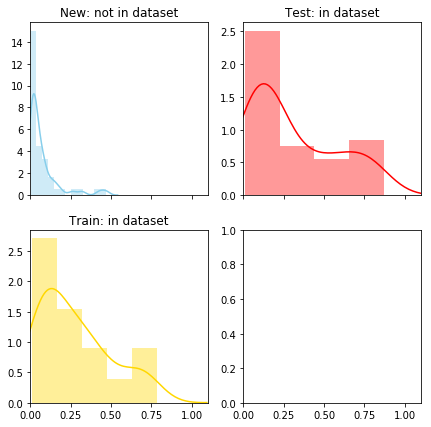

 32%|███▏      | 150004/473047 [2:55:18<625:46:22,  6.97s/it]

('New score: ', 0.07379447)
('Train score: ', 0.27606374)
('Test score: ', 0.30720273)


 33%|███▎      | 155000/473047 [3:00:50<3:15:49, 27.07it/s]  

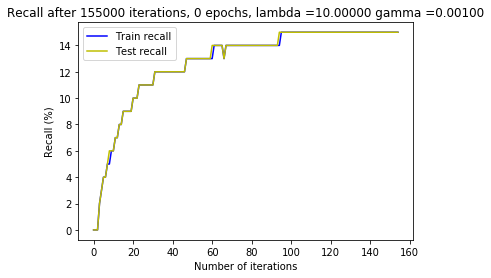

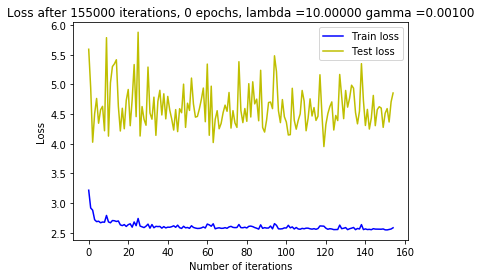

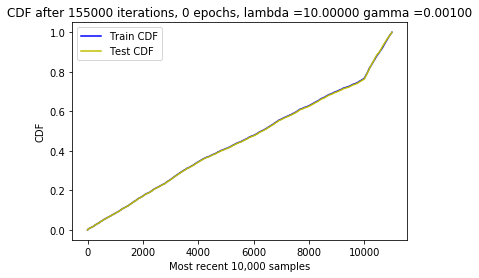

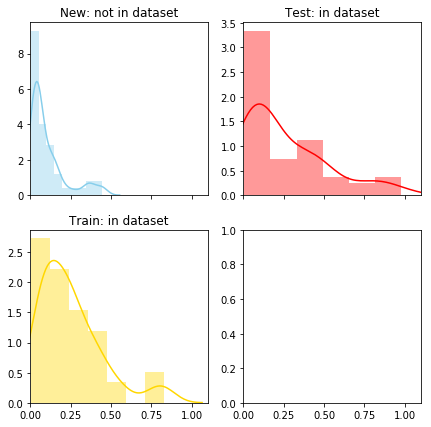

 33%|███▎      | 155004/473047 [3:01:12<614:06:11,  6.95s/it]

('New score: ', 0.10333058)
('Train score: ', 0.25221187)
('Test score: ', 0.25959733)


 34%|███▍      | 160000/473047 [3:06:40<3:14:02, 26.89it/s]  

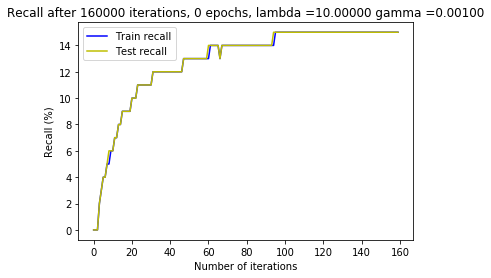

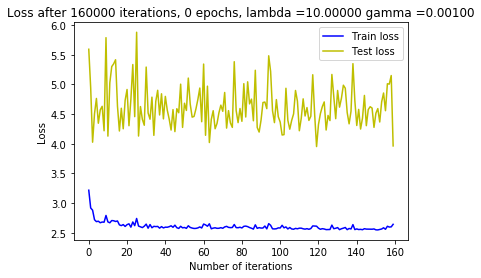

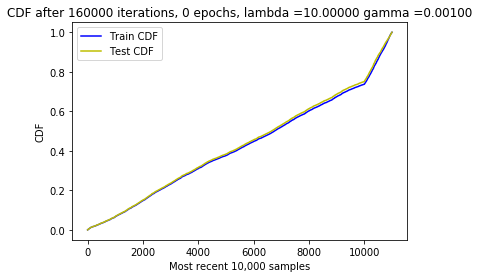

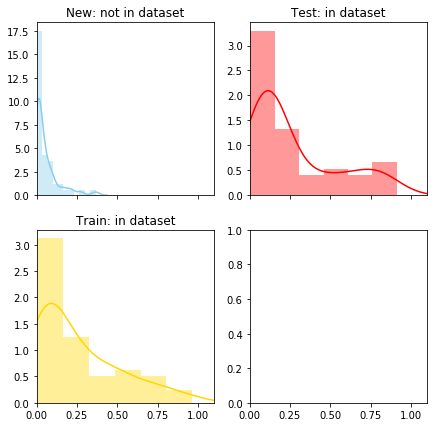

 34%|███▍      | 160004/473047 [3:07:03<604:09:49,  6.95s/it]

('New score: ', 0.054430604)
('Train score: ', 0.25696623)
('Test score: ', 0.2724844)


 35%|███▍      | 165000/473047 [3:12:40<3:43:42, 22.95it/s]  

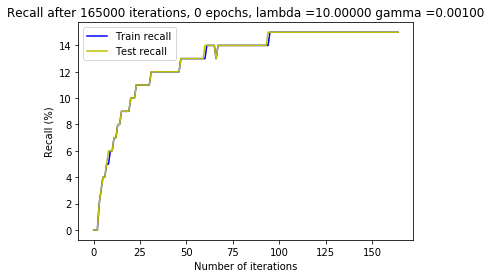

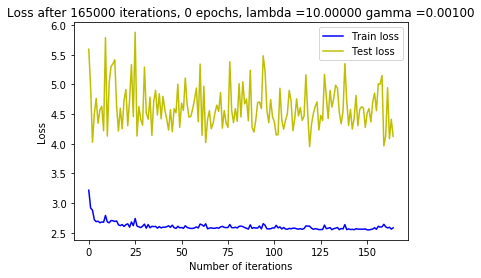

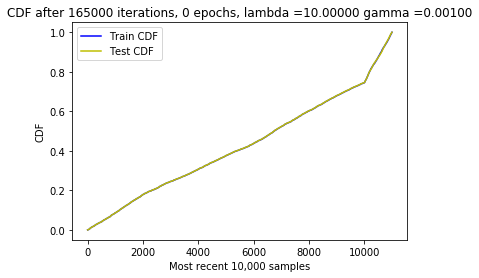

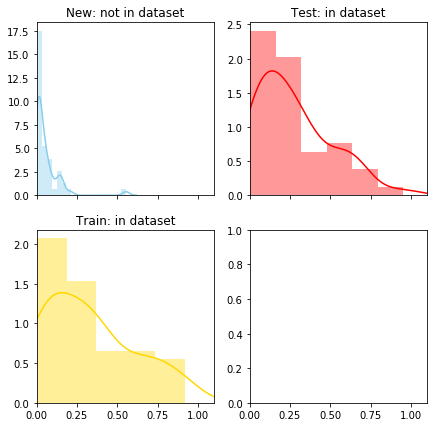

 35%|███▍      | 165004/473047 [3:12:55<596:33:18,  6.97s/it]

('New score: ', 0.05798805)
('Train score: ', 0.3340971)
('Test score: ', 0.27240688)


 36%|███▌      | 170000/473047 [3:18:30<3:39:12, 23.04it/s]  

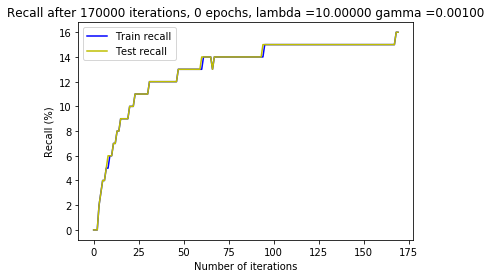

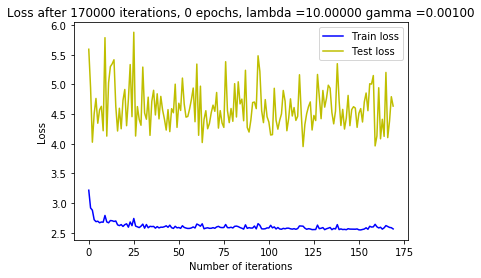

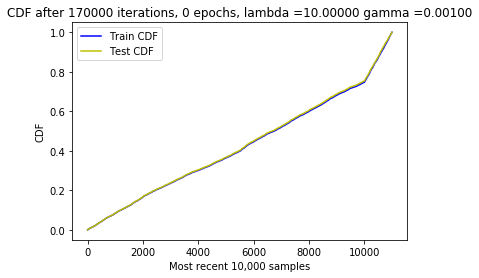

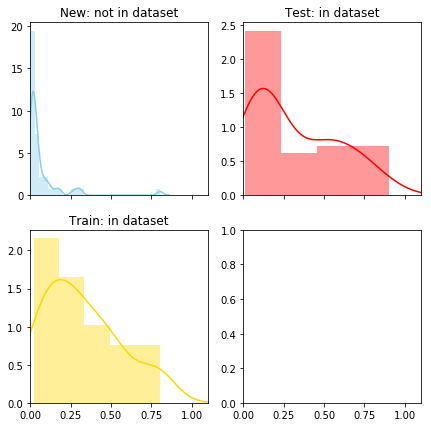

 36%|███▌      | 170004/473047 [3:18:43<575:36:24,  6.84s/it]

('New score: ', 0.06887642)
('Train score: ', 0.3245971)
('Test score: ', 0.31772006)


 37%|███▋      | 175000/473047 [3:24:20<3:37:55, 22.79it/s]  

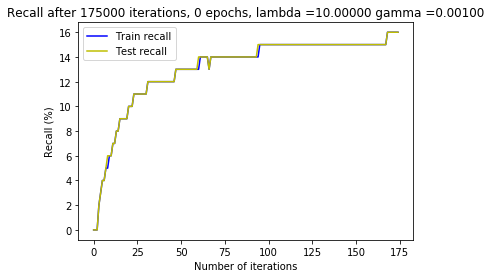

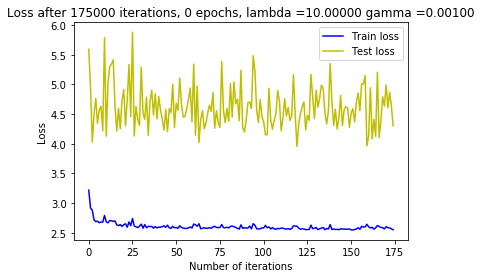

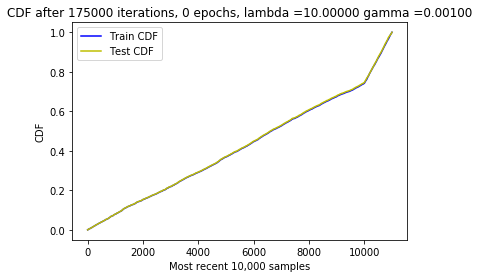

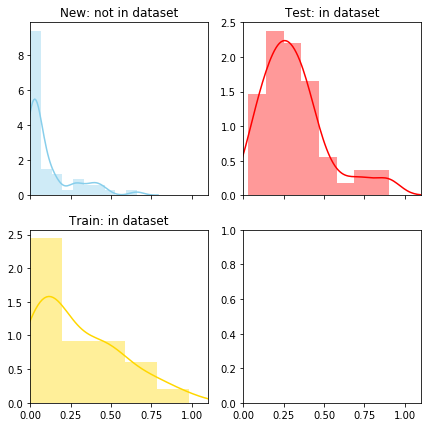

 37%|███▋      | 175004/473047 [3:24:36<599:42:10,  7.24s/it]

('New score: ', 0.112683505)
('Train score: ', 0.29874188)
('Test score: ', 0.3143154)


 38%|███▊      | 180000/473047 [3:30:10<3:01:14, 26.95it/s]  

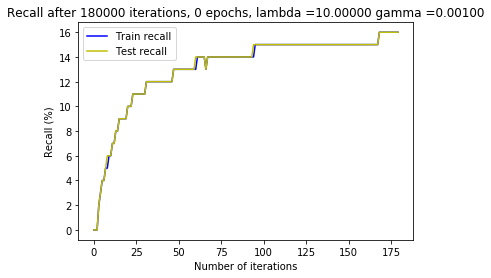

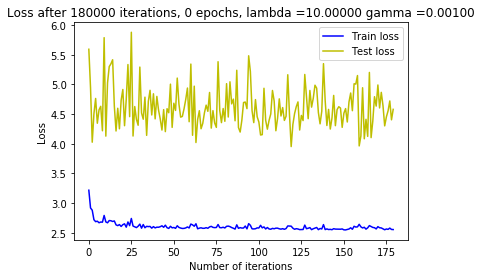

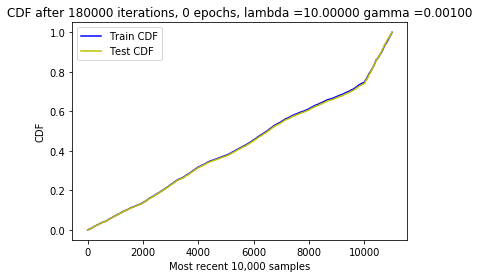

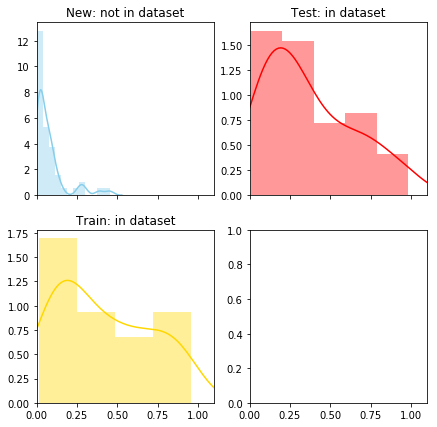

 38%|███▊      | 180004/473047 [3:30:30<569:52:30,  7.00s/it]

('New score: ', 0.07695161)
('Train score: ', 0.4151652)
('Test score: ', 0.36380914)


 39%|███▉      | 185000/473047 [3:36:00<2:51:17, 28.03it/s]  

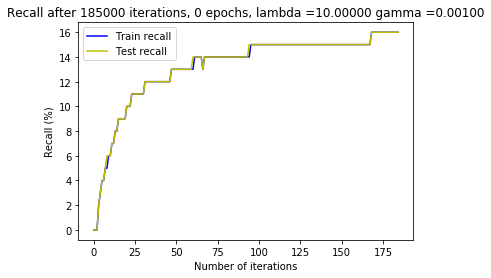

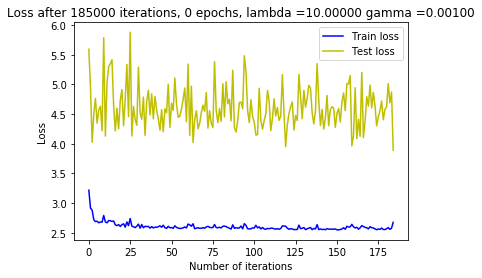

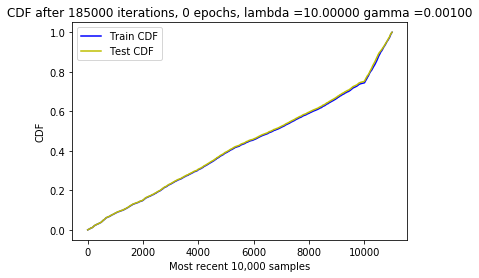

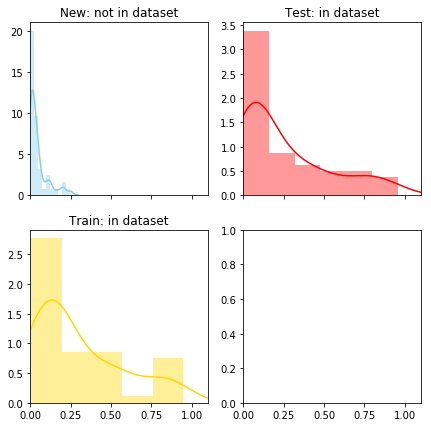

 39%|███▉      | 185004/473047 [3:36:22<558:59:44,  6.99s/it]

('New score: ', 0.046139013)
('Train score: ', 0.30263945)
('Test score: ', 0.2537853)


 40%|████      | 190000/473047 [3:41:50<2:52:44, 27.31it/s]  

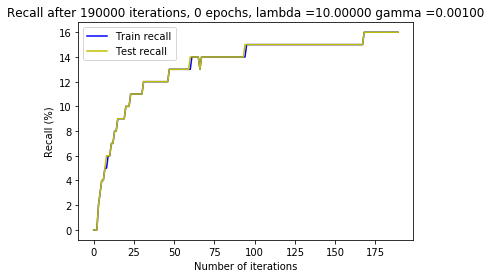

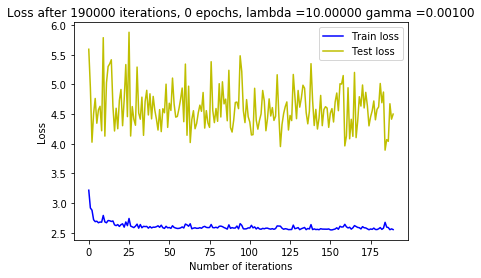

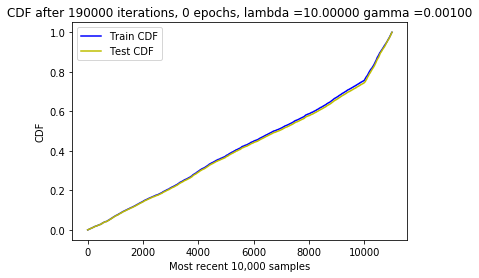

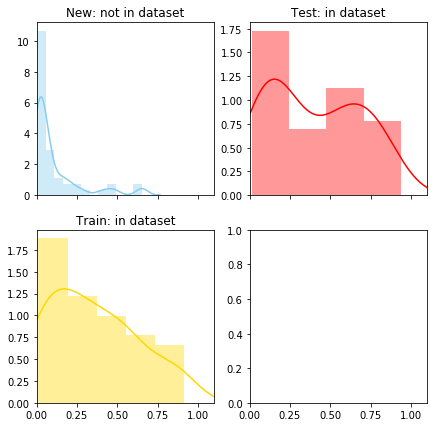

 40%|████      | 190004/473047 [3:42:09<549:57:30,  6.99s/it]

('New score: ', 0.10867872)
('Train score: ', 0.35445523)
('Test score: ', 0.39879856)


 41%|████      | 195000/473047 [3:47:40<3:22:42, 22.86it/s]  

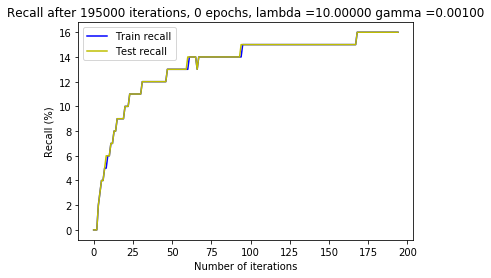

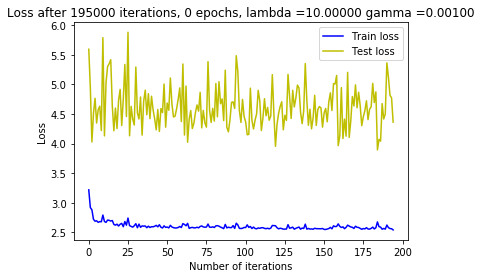

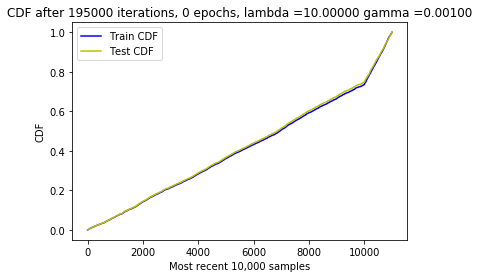

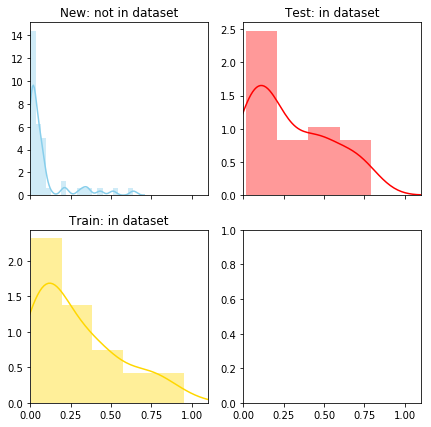

 41%|████      | 195004/473047 [3:48:02<539:12:15,  6.98s/it]

('New score: ', 0.08782711)
('Train score: ', 0.28898296)
('Test score: ', 0.29330713)


 42%|████▏     | 200000/473047 [3:53:30<2:49:36, 26.83it/s]  

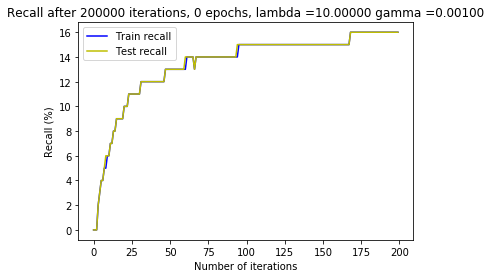

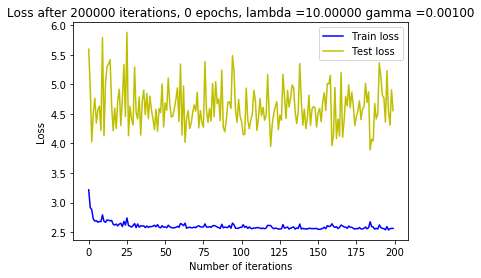

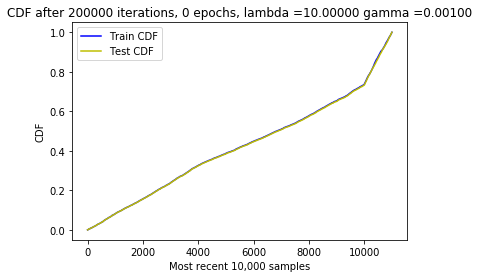

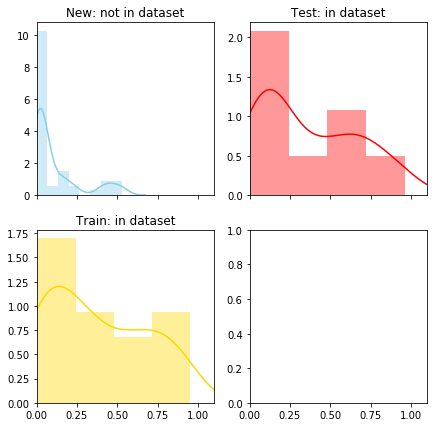

 42%|████▏     | 200004/473047 [3:53:50<528:34:31,  6.97s/it]

('New score: ', 0.11082652)
('Train score: ', 0.37876263)
('Test score: ', 0.36406478)


 43%|████▎     | 205000/473047 [3:59:21<2:47:11, 26.72it/s]  

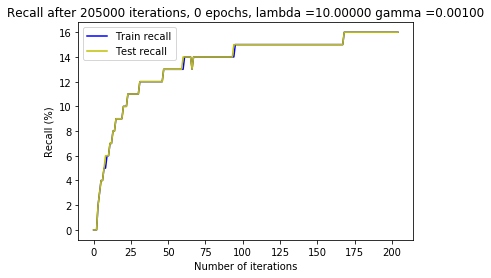

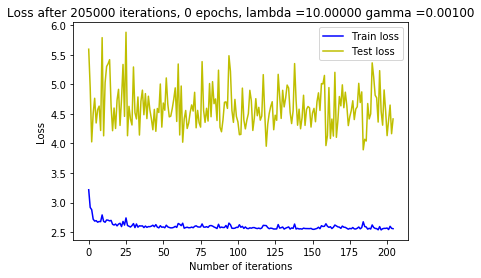

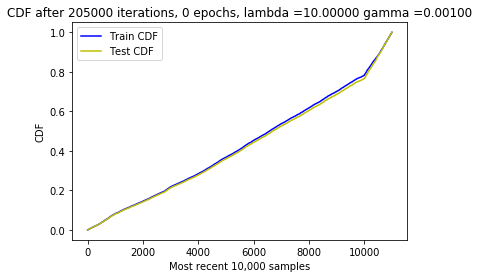

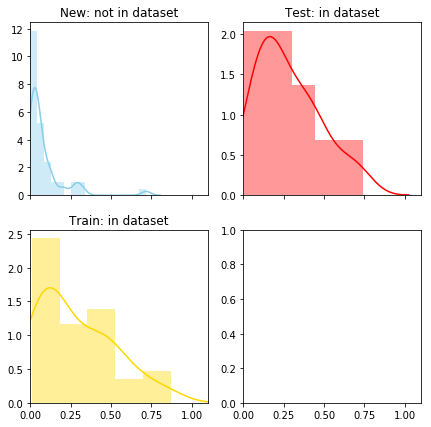

 43%|████▎     | 205004/473047 [3:59:38<517:51:15,  6.96s/it]

('New score: ', 0.0840422)
('Train score: ', 0.2869874)
('Test score: ', 0.28014407)


 44%|████▍     | 208925/473047 [4:03:40<2:42:27, 27.10it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 45%|████▌     | 215000/473047 [4:10:51<2:35:27, 27.66it/s]

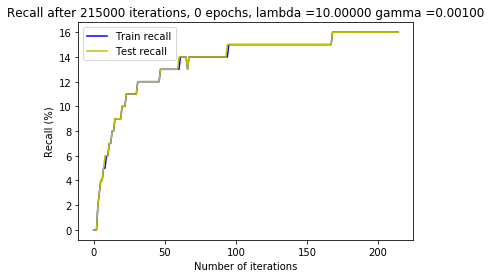

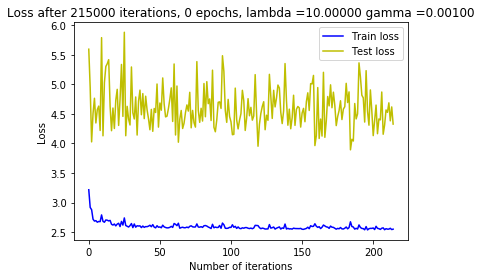

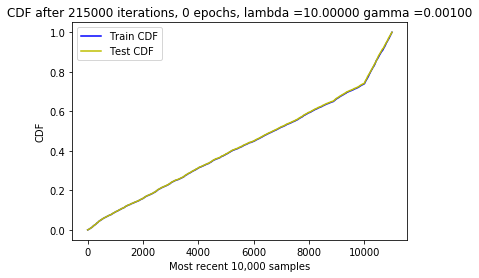

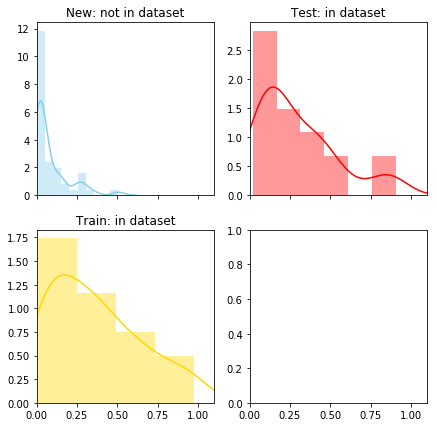

 45%|████▌     | 215004/473047 [4:11:11<503:10:11,  7.02s/it]

('New score: ', 0.082381375)
('Train score: ', 0.36189285)
('Test score: ', 0.2969636)


 47%|████▋     | 220000/473047 [4:16:31<2:38:03, 26.68it/s]  

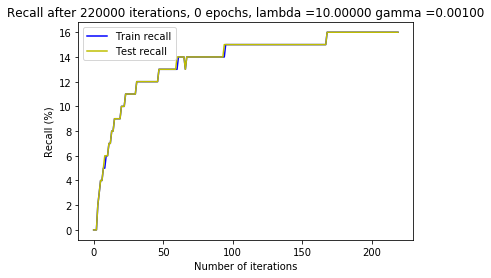

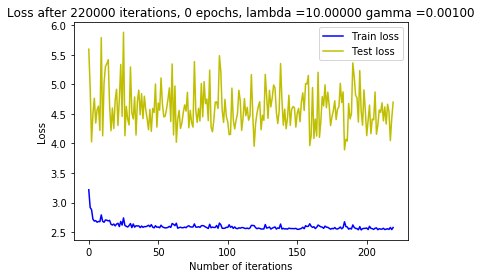

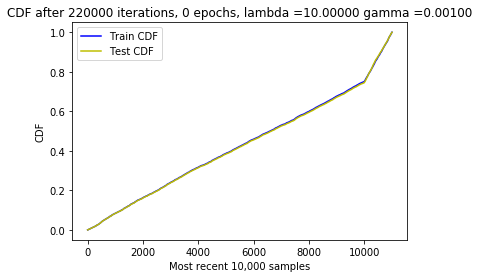

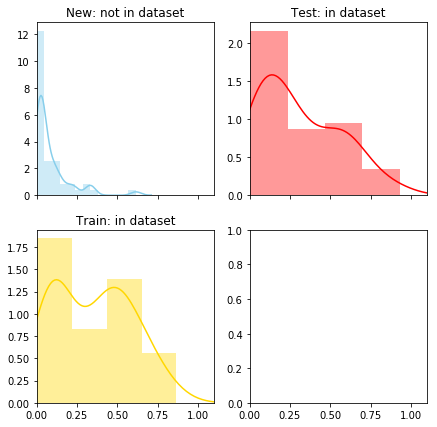

 47%|████▋     | 220004/473047 [4:16:54<493:24:44,  7.02s/it]

('New score: ', 0.08680415)
('Train score: ', 0.34891614)
('Test score: ', 0.30756938)


 47%|████▋     | 223000/473047 [4:19:54<2:34:30, 26.97it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 229000/473047 [4:26:55<2:33:20, 26.53it/s]

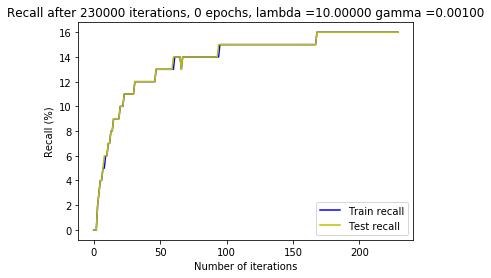

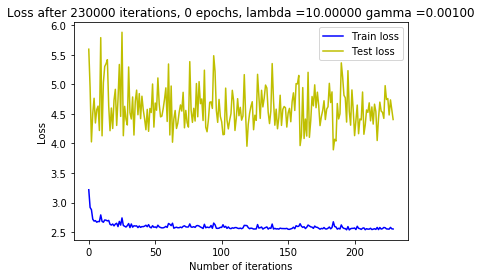

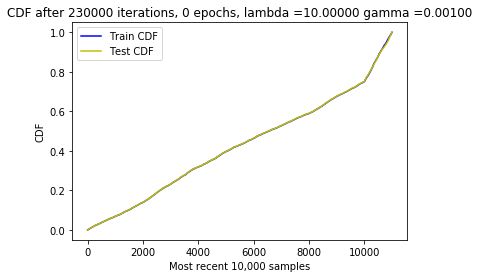

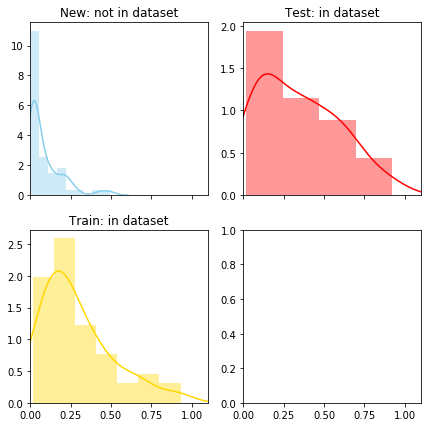

 49%|████▊     | 230004/473047 [4:28:39<473:15:38,  7.01s/it]

('New score: ', 0.085960515)
('Train score: ', 0.28986844)
('Test score: ', 0.34398678)


 50%|████▉     | 235000/473047 [4:34:11<2:27:07, 26.97it/s]  

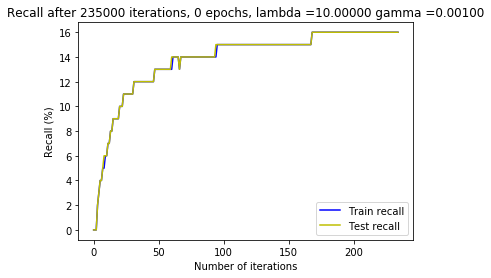

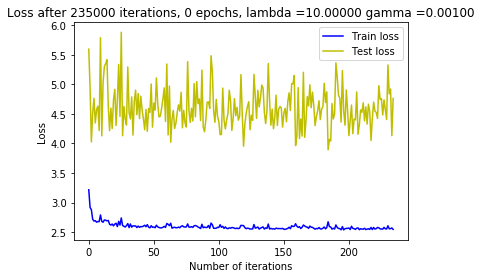

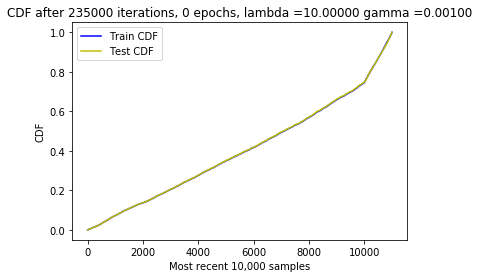

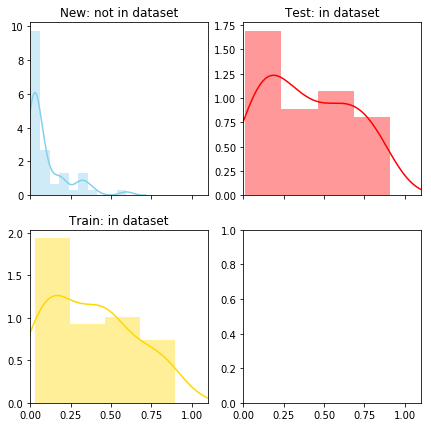

 50%|████▉     | 235004/473047 [4:34:27<460:10:25,  6.96s/it]

('New score: ', 0.099856555)
('Train score: ', 0.3783767)
('Test score: ', 0.40109032)


 51%|█████     | 238928/473047 [4:38:30<2:26:11, 26.69it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 245000/473047 [4:45:51<2:22:28, 26.68it/s]

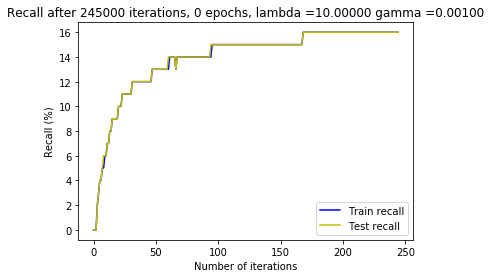

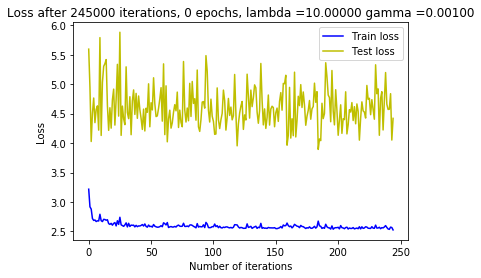

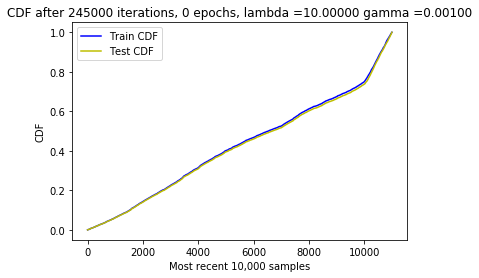

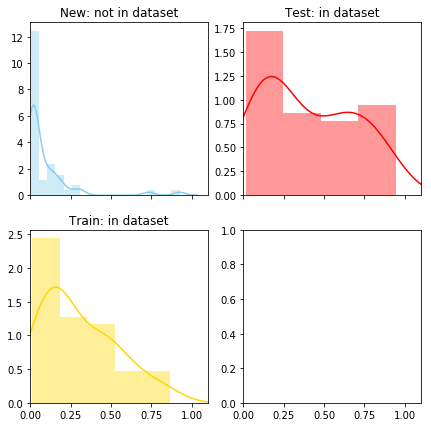

 52%|█████▏    | 245004/473047 [4:46:06<438:48:28,  6.93s/it]

('New score: ', 0.09487884)
('Train score: ', 0.3055877)
('Test score: ', 0.4011334)


 53%|█████▎    | 250000/473047 [4:51:31<2:18:08, 26.91it/s]  

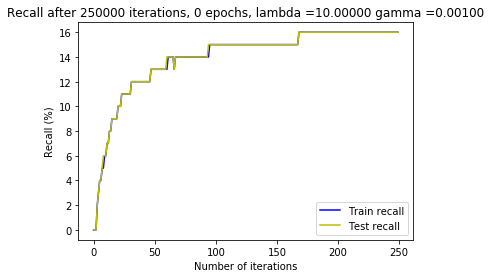

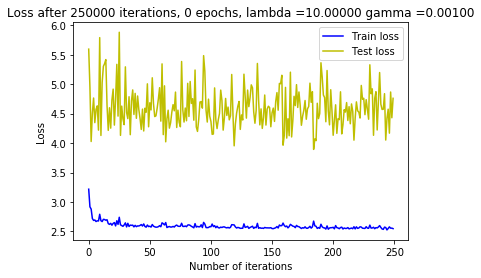

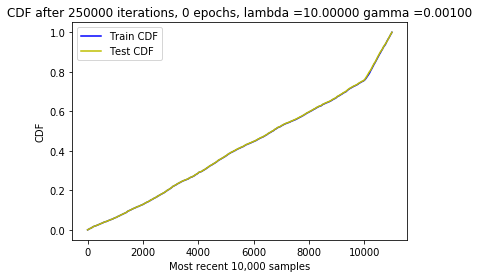

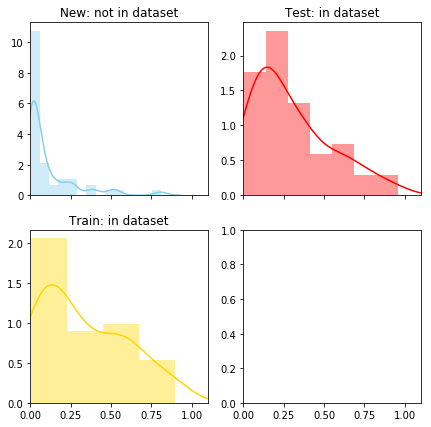

 53%|█████▎    | 250004/473047 [4:51:54<429:43:41,  6.94s/it]

('New score: ', 0.10782686)
('Train score: ', 0.33002195)
('Test score: ', 0.2985851)


 54%|█████▎    | 253292/473047 [4:55:32<2:15:50, 26.96it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 55%|█████▍    | 260000/473047 [5:03:11<2:12:16, 26.84it/s]  

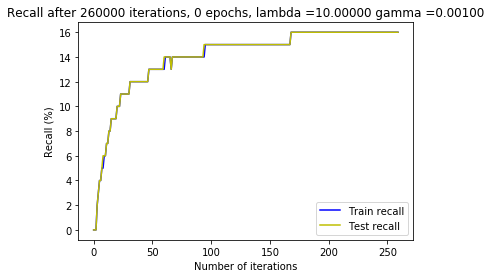

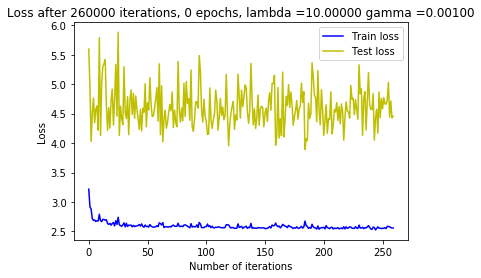

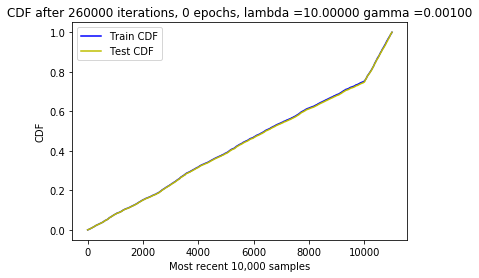

 58%|█████▊    | 275000/473047 [5:20:31<2:02:45, 26.89it/s]  

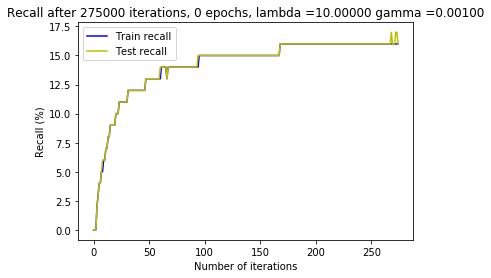

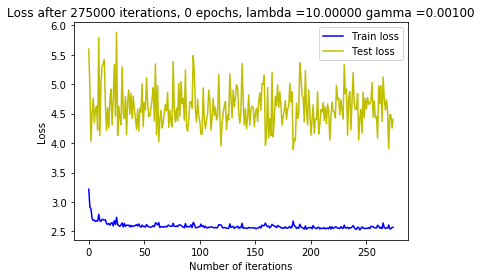

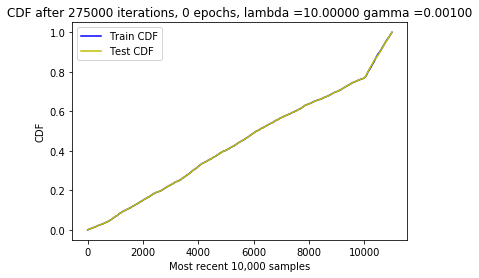

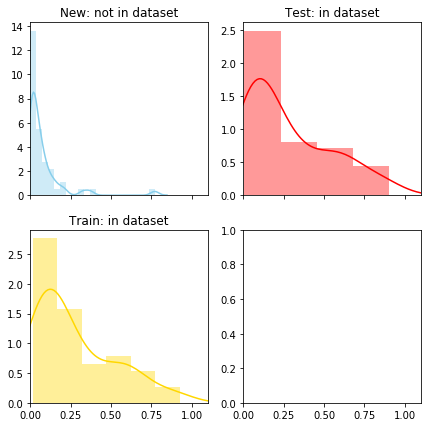

 58%|█████▊    | 275004/473047 [5:20:53<381:32:47,  6.94s/it]

('New score: ', 0.07752344)
('Train score: ', 0.27701843)
('Test score: ', 0.27738148)


 61%|██████▏   | 290000/473047 [5:37:51<1:53:15, 26.94it/s]  

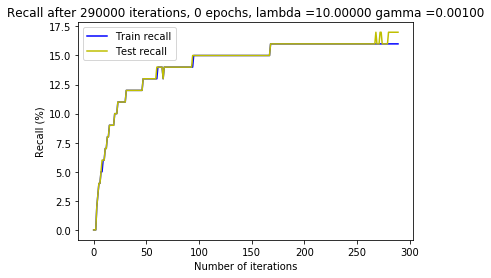

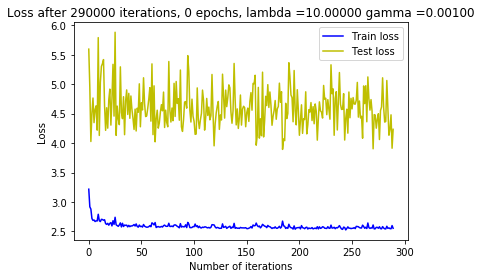

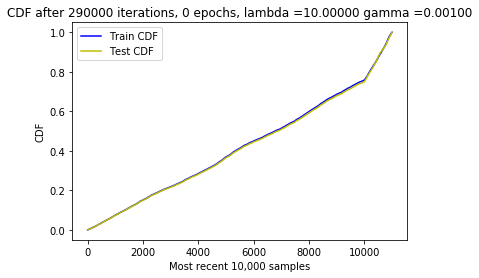

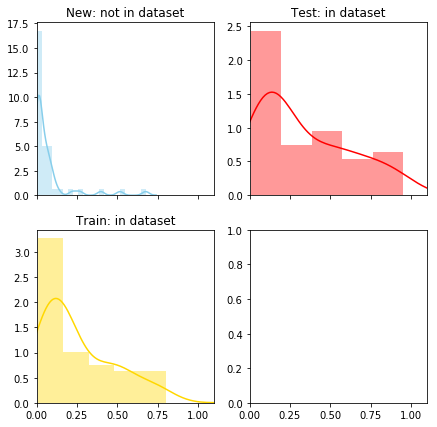

 61%|██████▏   | 290004/473047 [5:38:08<349:19:40,  6.87s/it]

('New score: ', 0.07279387)
('Train score: ', 0.2547294)
('Test score: ', 0.33722228)


 62%|██████▏   | 295000/473047 [5:43:41<2:08:53, 23.02it/s]  

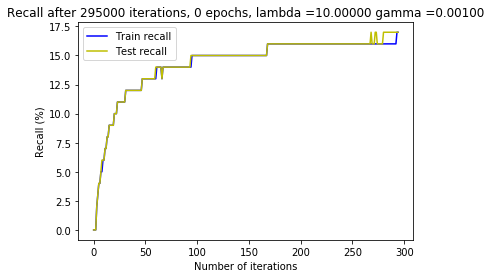

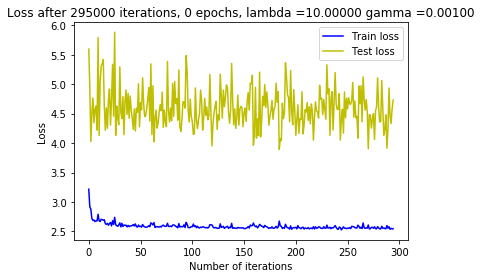

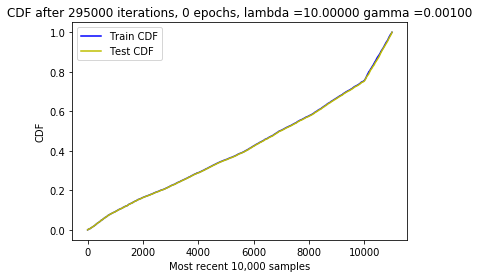

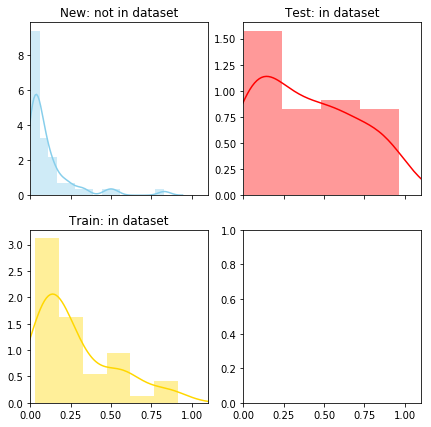

 62%|██████▏   | 295004/473047 [5:43:59<338:50:11,  6.85s/it]

('New score: ', 0.113064595)
('Train score: ', 0.27895132)
('Test score: ', 0.3931412)


 63%|██████▎   | 297844/473047 [5:46:47<1:47:39, 27.12it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 64%|██████▍   | 305000/473047 [5:55:21<1:44:33, 26.79it/s]  

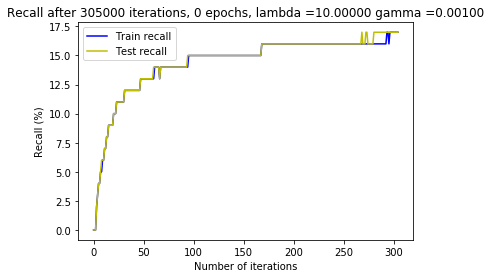

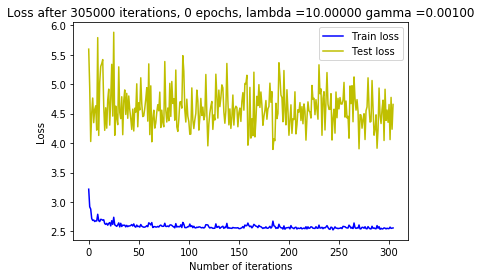

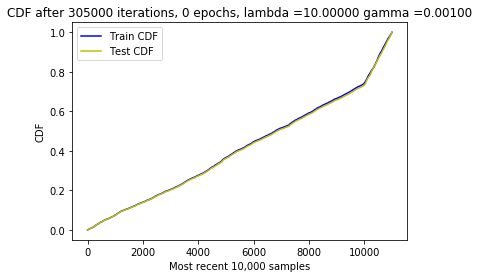

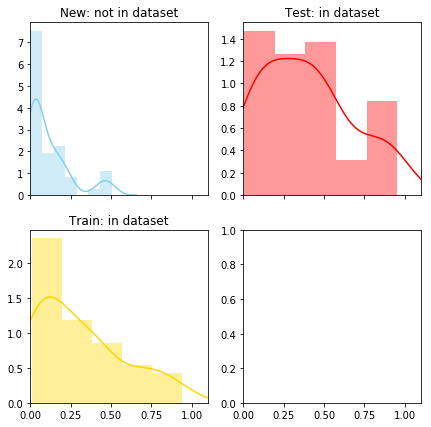

 64%|██████▍   | 305004/473047 [5:55:38<325:33:28,  6.97s/it]

('New score: ', 0.1163843)
('Train score: ', 0.30908906)
('Test score: ', 0.39144957)


 66%|██████▌   | 310000/473047 [6:01:11<1:40:54, 26.93it/s]  

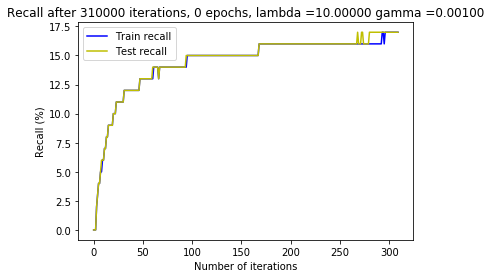

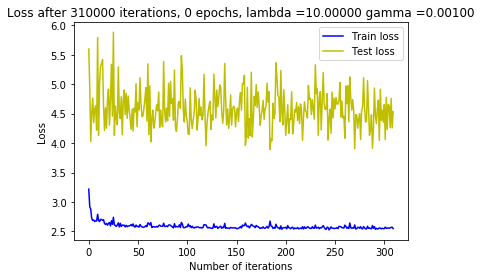

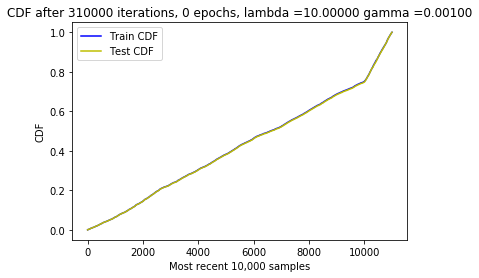

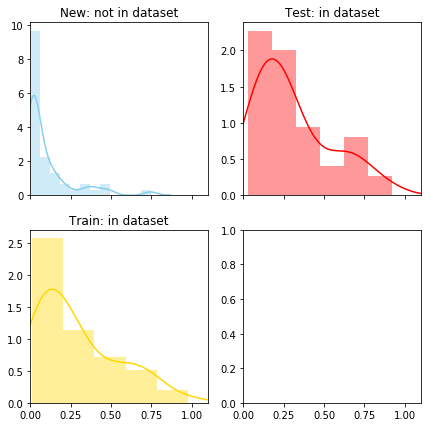

 66%|██████▌   | 310004/473047 [6:01:27<315:28:39,  6.97s/it]

('New score: ', 0.10181739)
('Train score: ', 0.29124984)
('Test score: ', 0.30582398)


 66%|██████▌   | 312160/473047 [6:03:52<1:40:05, 26.79it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 68%|██████▊   | 320000/473047 [6:12:51<1:34:05, 27.11it/s]  

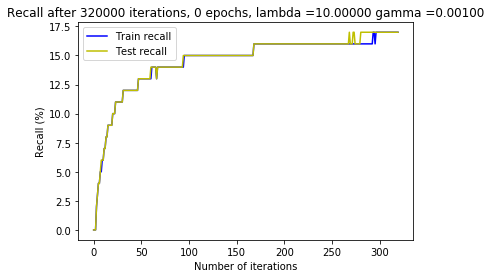

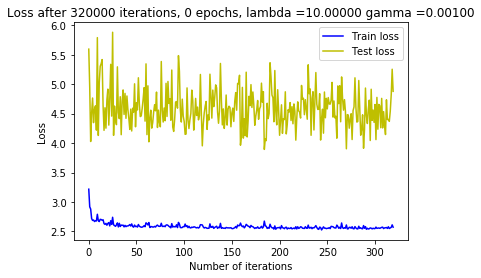

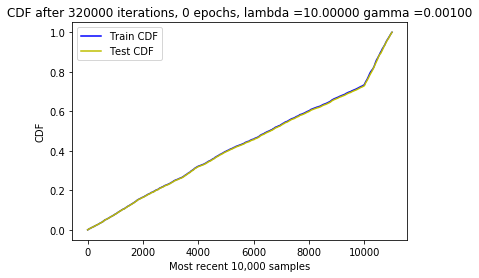

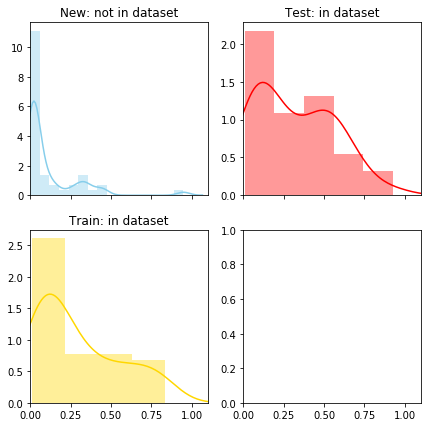

 68%|██████▊   | 320004/473047 [6:13:08<296:46:44,  6.98s/it]

('New score: ', 0.1126862)
('Train score: ', 0.29547307)
('Test score: ', 0.31928194)


 69%|██████▊   | 325000/473047 [6:18:41<1:32:04, 26.80it/s]  

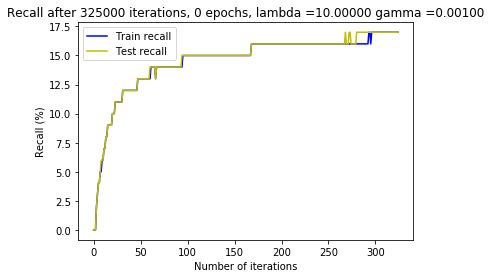

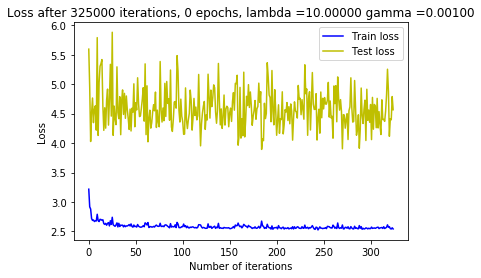

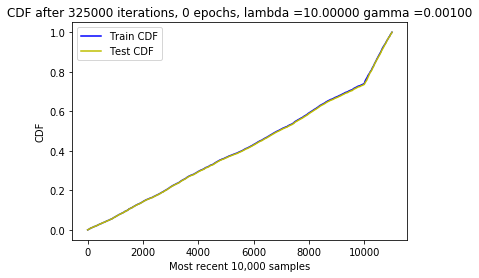

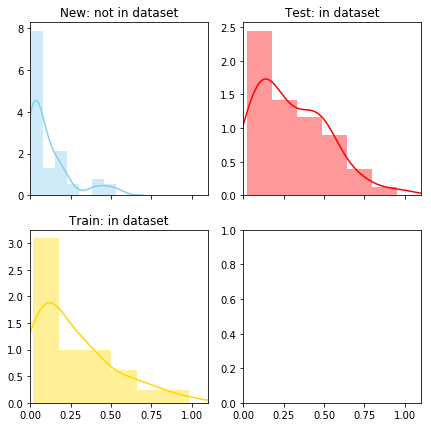

 69%|██████▊   | 325004/473047 [6:18:59<284:59:03,  6.93s/it]

('New score: ', 0.10830965)
('Train score: ', 0.27185133)
('Test score: ', 0.2993901)


 69%|██████▉   | 326697/473047 [6:20:35<1:29:38, 27.21it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 71%|███████   | 335000/473047 [6:30:11<1:24:08, 27.34it/s]  

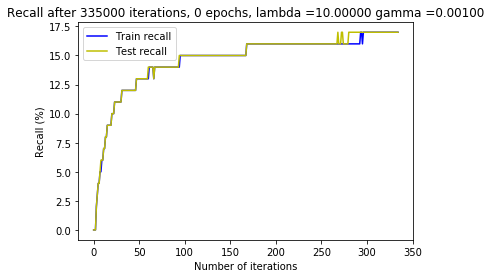

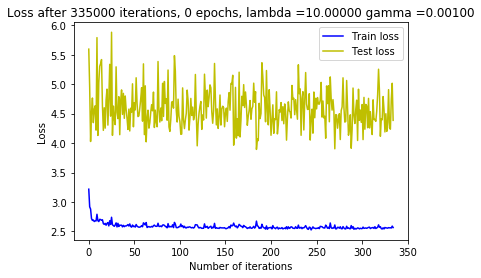

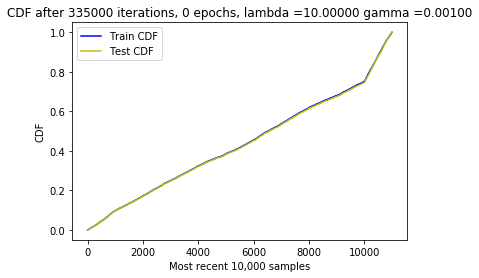

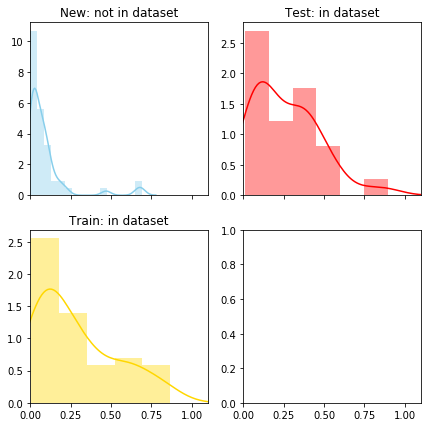

 71%|███████   | 335004/473047 [6:30:27<259:42:54,  6.77s/it]

('New score: ', 0.09254012)
('Train score: ', 0.2839691)
('Test score: ', 0.2648002)


 72%|███████▏  | 340000/473047 [6:35:51<1:21:41, 27.14it/s]  

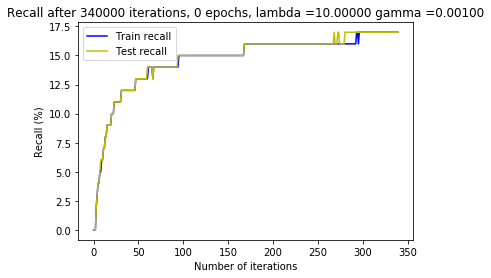

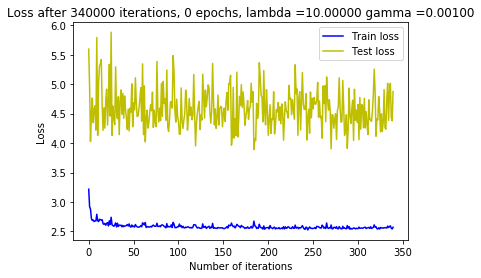

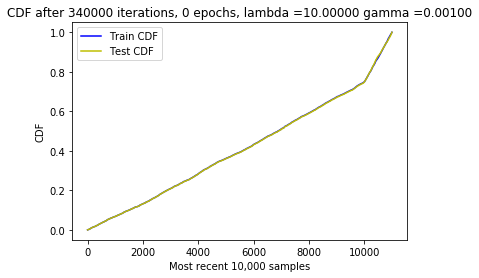

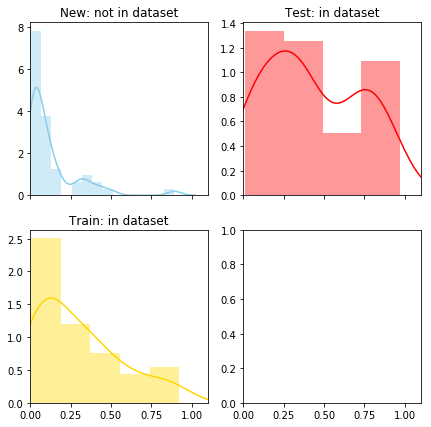

 72%|███████▏  | 340004/473047 [6:36:10<251:22:43,  6.80s/it]

('New score: ', 0.12653902)
('Train score: ', 0.2975986)
('Test score: ', 0.4293172)


 72%|███████▏  | 341484/473047 [6:37:37<1:21:23, 26.94it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▍  | 350000/473047 [6:47:21<1:16:01, 26.97it/s]  

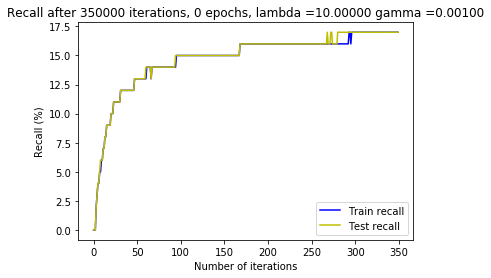

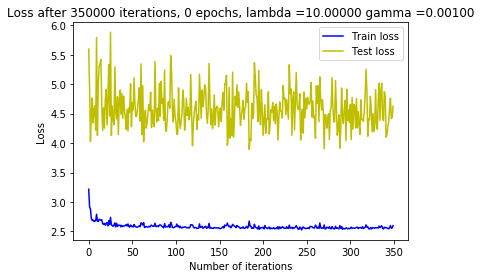

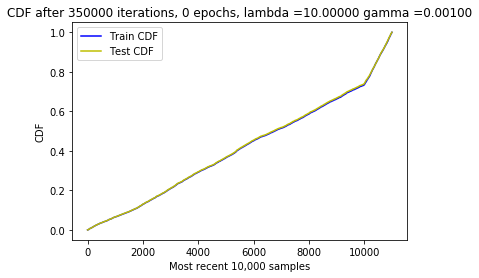

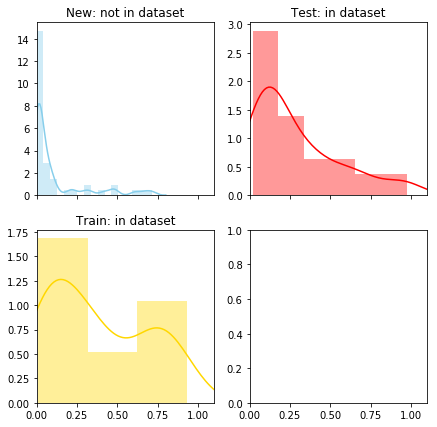

 74%|███████▍  | 350004/473047 [6:47:42<236:48:41,  6.93s/it]

('New score: ', 0.112389214)
('Train score: ', 0.38268498)
('Test score: ', 0.29064962)


 75%|███████▌  | 355000/473047 [6:53:11<1:12:04, 27.30it/s]  

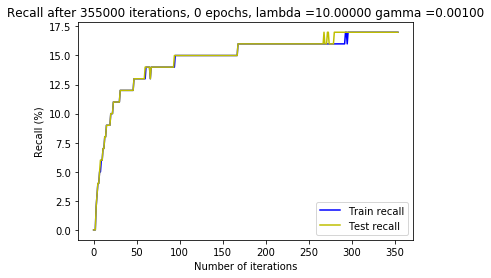

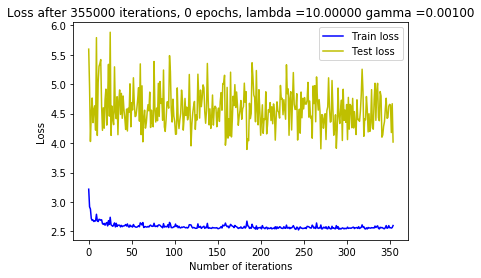

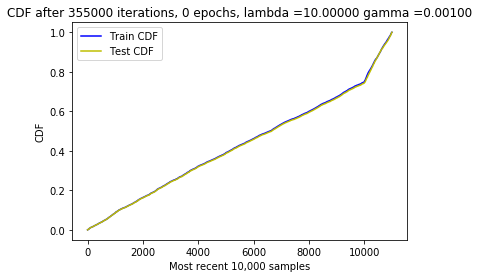

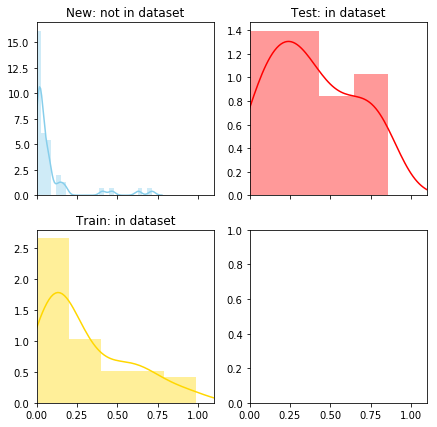

 75%|███████▌  | 355004/473047 [6:53:27<224:44:40,  6.85s/it]

('New score: ', 0.08493556)
('Train score: ', 0.30099553)
('Test score: ', 0.39040756)


 75%|███████▌  | 356565/473047 [6:55:01<1:12:52, 26.64it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 77%|███████▋  | 365000/473047 [7:05:01<1:07:10, 26.81it/s]  

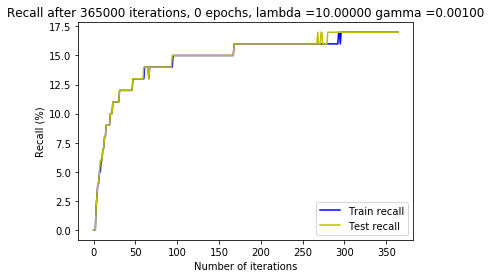

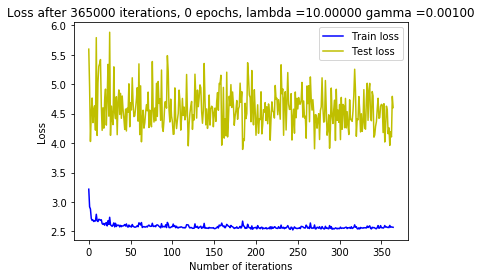

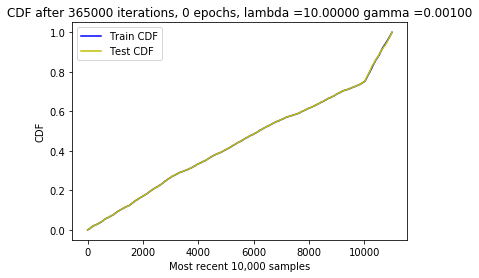

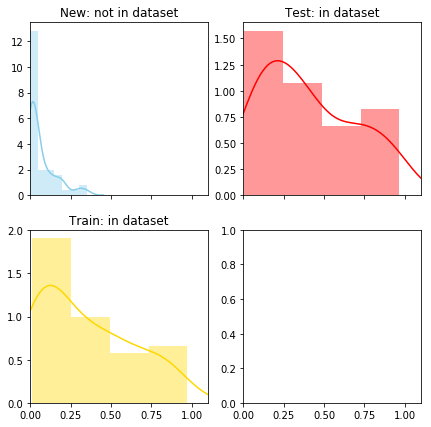

 77%|███████▋  | 365004/473047 [7:05:19<219:16:45,  7.31s/it]

('New score: ', 0.066883095)
('Train score: ', 0.34416005)
('Test score: ', 0.40008724)


 78%|███████▊  | 370000/473047 [7:10:51<1:04:00, 26.83it/s]  

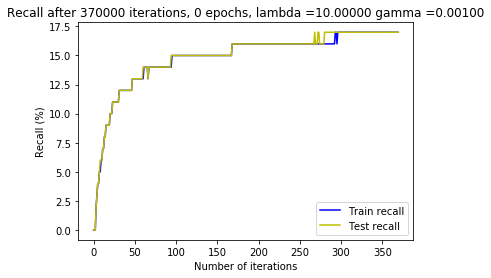

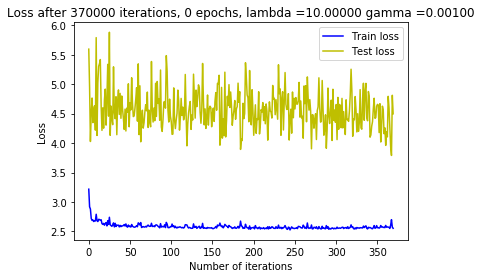

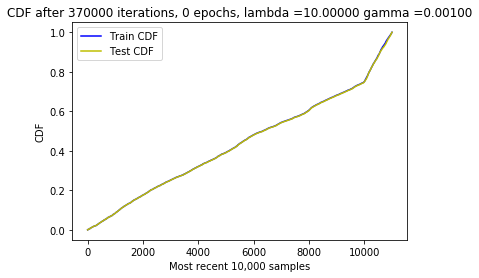

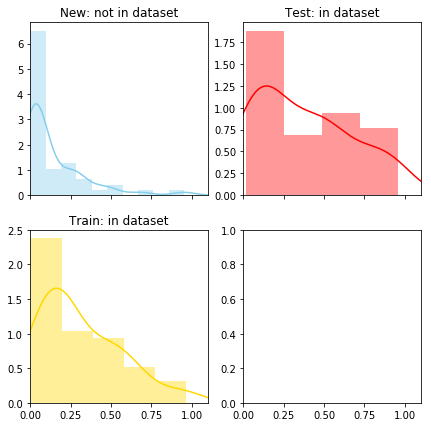

 78%|███████▊  | 370004/473047 [7:11:08<199:37:12,  6.97s/it]

('New score: ', 0.14144972)
('Train score: ', 0.31247503)
('Test score: ', 0.37796065)


 78%|███████▊  | 370349/473047 [7:11:21<1:03:13, 27.07it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 79%|███████▉  | 375000/473047 [7:16:41<1:00:43, 26.91it/s]

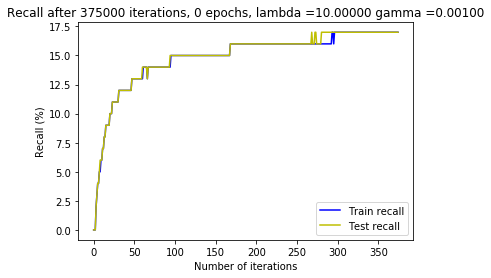

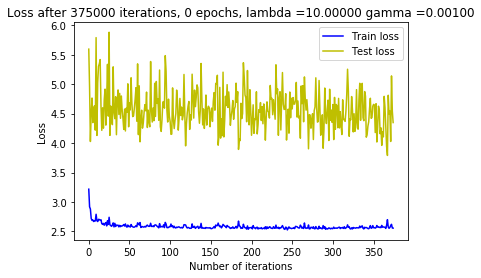

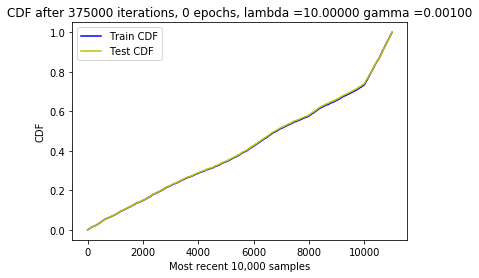

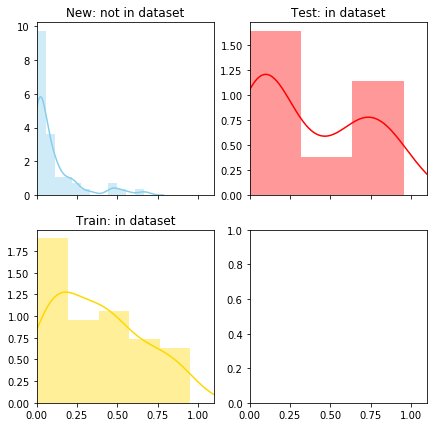

 79%|███████▉  | 375004/473047 [7:16:58<190:26:04,  6.99s/it]

('New score: ', 0.10572482)
('Train score: ', 0.37859824)
('Test score: ', 0.38051498)


 80%|████████  | 380000/473047 [7:22:31<57:30, 26.97it/s]    

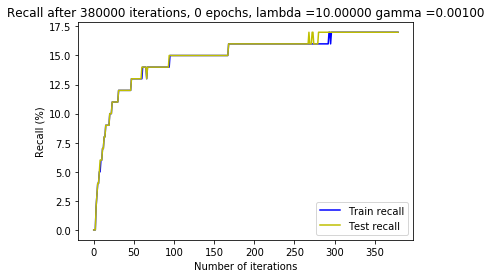

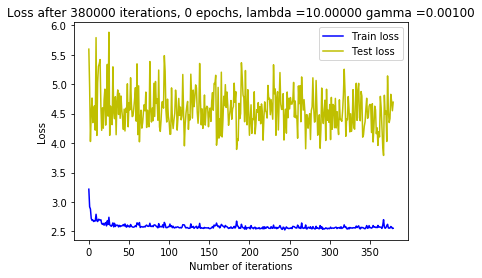

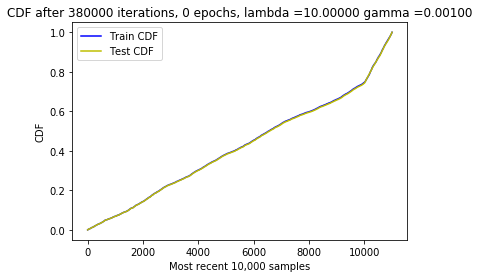

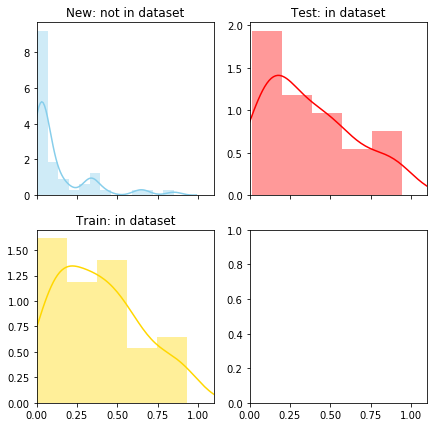

 80%|████████  | 380004/473047 [7:22:48<180:09:39,  6.97s/it]

('New score: ', 0.13105033)
('Train score: ', 0.3831671)
('Test score: ', 0.36810493)


 81%|████████▏ | 385000/473047 [7:28:21<54:30, 26.92it/s]    

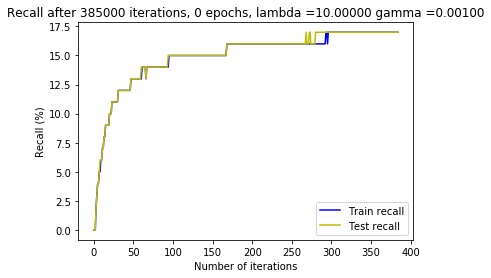

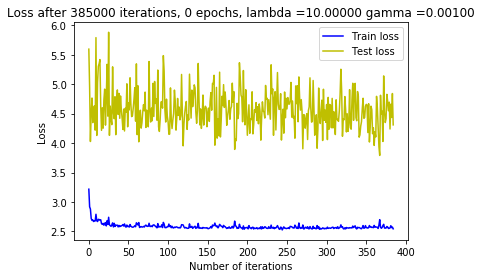

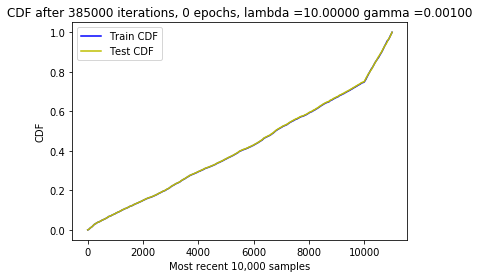

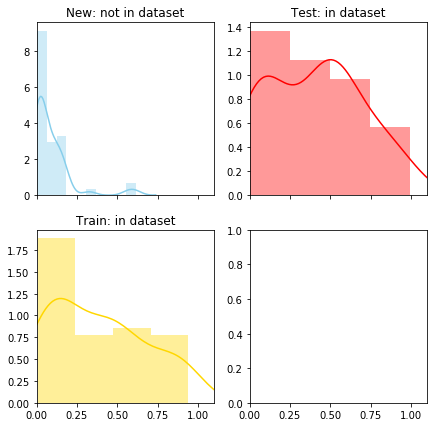

 81%|████████▏ | 385004/473047 [7:28:36<170:47:38,  6.98s/it]

('New score: ', 0.08808731)
('Train score: ', 0.38626847)
('Test score: ', 0.40788117)


 82%|████████▏ | 390000/473047 [7:34:11<51:14, 27.01it/s]    

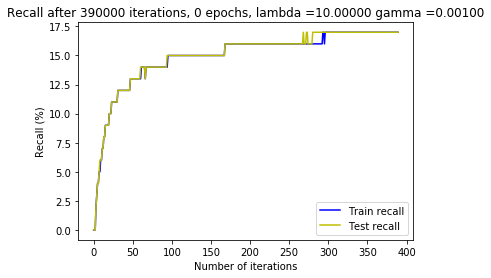

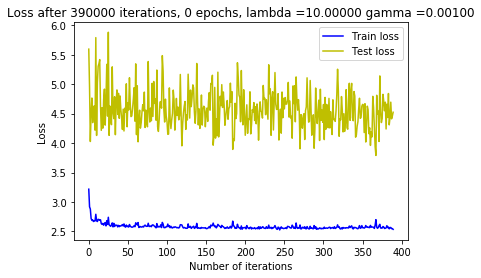

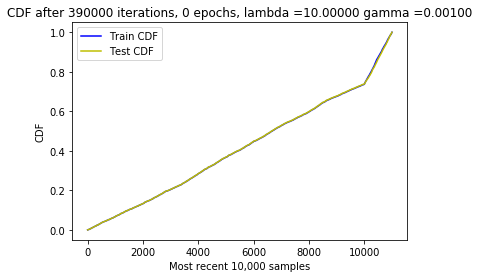

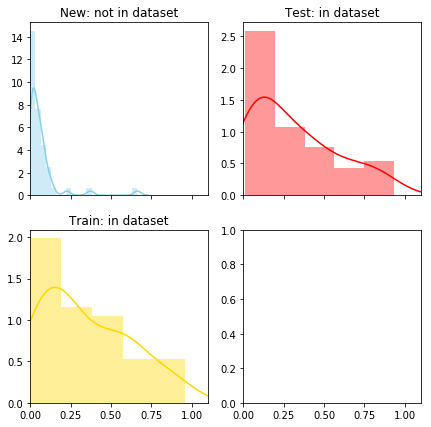

 82%|████████▏ | 390004/473047 [7:34:26<161:23:31,  7.00s/it]

('New score: ', 0.06546716)
('Train score: ', 0.3478647)
('Test score: ', 0.31181616)


 84%|████████▎ | 395000/473047 [7:40:02<48:07, 27.03it/s]    

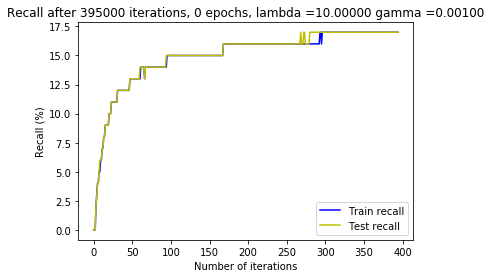

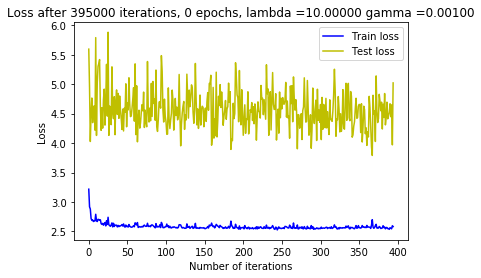

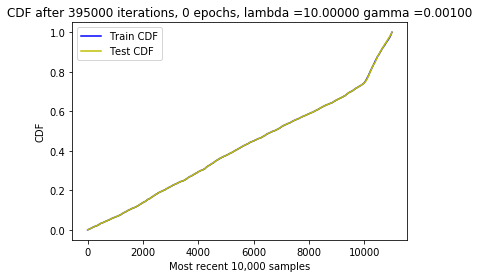

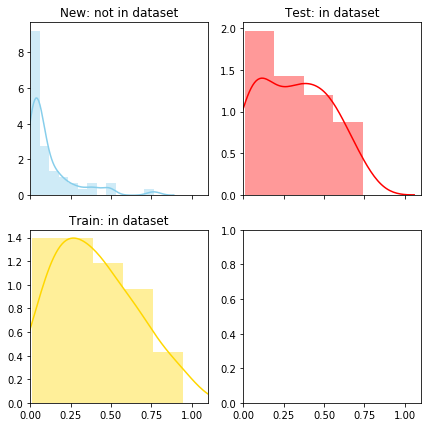

 84%|████████▎ | 395004/473047 [7:40:16<151:27:32,  6.99s/it]

('New score: ', 0.11965626)
('Train score: ', 0.39561236)
('Test score: ', 0.3153657)


 91%|█████████ | 429532/473047 [8:20:10<31:38, 22.92it/s]    

In [ ]:
for g in gammas:
    for l in lambdas:
        print("Lambda: " + str(l) + " Gamma: " + str(g))
        model = MoreComplexNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=g, lamb=l, save_checkpoints=True)

In [ ]:
# For loading the checkpointed model
# for g in range(len(gammas)):
#     for l in range(len(lambdas)):
#         model = SimpleConvNet()
#         optim = SGD(model.parameters(), lr=gamma)
#         checkpoint = torch.load('../models/model.pth')
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         model.to(device)
#         sgd(gamma=gammas[g], lamb=lambdas[l])        